##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Lev Droplet 

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/basic_regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

NN for predicting ST from theoretical data based on the somple model

In [1]:
import numpy as np
import os
import re
import glob
import matplotlib.pyplot as plt
from scipy.signal import  gaussian
from scipy.ndimage import filters
from scipy import optimize
from scipy.stats import linregress
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

import scipy as sp
import scipy.interpolate
from scipy.integrate import trapz

import time

import pandas as pd

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import pprint
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import io
from scipy.interpolate import interp1d

from scipy.stats import gaussian_kde
from matplotlib.colors import Normalize 
from matplotlib import cm

from sklearn.utils import shuffle

from numpy.random import seed

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


###############################################################################
#### Functions used in the data processing ####################################
###############################################################################

def calc_R_sph(vol):
    """
    Calculate the spherical radius of a droplet based on the volume.

    Input parameters
    ----------
    vol:         volume   [pixels**3]
    calibration: calibration factor  [mm**3/pixels**3]

    Returns
    -------
    Corresponding spherical radius.  [mm]

    """
    R_sph=(3*vol/(4*np.pi))**(1/3)
    return R_sph



def R_predict(th, gamma, R_sph, Ps, Cg_air, k_o):
    """
    Prediction of ST. 
    After the acoustic pressure is determined. The ST is calculated based on the equation of our model. 
    
    
    Input parameters
    ----------
    th:     angle theta
    gamma:  ST as initial predition [mN/m]
    Power:  U*I [Watt]
    Returns
    -------
    gamma:   predicted surface tension [mN/m]

    """    
#    Ps=data_Ps[i-1]    #[Pa]
    ct_new=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))*(3*(np.cos(th))**2-1)
    return ct_new+R_sph


def azimuth(x, y):
    """
    Calculate the azimuthal angle.
    Input parameters
    ----------
    x, y: Cartesian coordinates of contour of the drop [mm]
    Returns
    -------
    Azimuthal angle in [rad]
    """
    a=np.arctan2(x, y)
    return a

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)


def pol2cart_theta(rho, theta):
    x = rho * np.sin(theta)
    y = rho * np.cos(theta)
    return(x, y)

    
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx


#Min-Max transformation

def MinMaxTransformTrain(train_dataset, points):

  max_rho=[]
  min_rho=[]
  # min_theta=[]
  # max_theta=[]
  for i in range(len(train_dataset)):
    max_rho.append(max(train_dataset.iloc[i, 0:points].values))
    min_rho.append(min(train_dataset.iloc[i, 0:points].values))
    # max_theta.append(max(train_dataset.iloc[i, points:2*points].values))
    # min_theta.append(min(train_dataset.iloc[i, points:2*points].values))

  # print(min(min_rho), max(max_rho), min(min_theta), max(max_theta))

  # Change the range of rho from 0 to 1

  OldMax= max(max_rho)
  OldMin=min(min_rho)

  NewValues_rho={}

  OldRange = (OldMax - OldMin)
  for i in range(len(train_dataset)):
    if (OldRange == 0):
        NewValue = OldMin
        NewValues_rho[i]=NewValue
    else:
        NewValue = (train_dataset.iloc[i, 0:points] - OldMin)/(OldMax-OldMin) 
        NewValues_rho[i]=NewValue

  # Change the range of theta from 0 to 1

  # OldMax= max(max_theta)
  # OldMin=min(min_theta)

  # NewValues_theta={}

  # OldRange = (OldMax - OldMin)
  # for i in range(len(train_dataset)):
  #   if (OldRange == 0):
  #       NewValue = OldMin
  #       NewValues_theta[i]=NewValue
  #   else:
  #       NewValue = (train_dataset.iloc[i, points:2*points] - OldMin)/(OldMax-OldMin) 
  #       NewValues_theta[i]=NewValue

  df_rho=pd.DataFrame.from_dict(NewValues_rho).T
  # df_theta=pd.DataFrame.from_dict(NewValues_theta).T

  # new_df=pd.concat([df_rho, df_theta], axis=1)

  return df_rho


def MinMaxTransformTest(test_dataset, train_dataset, points):

  max_rho=[]
  min_rho=[]
  # min_theta=[]
  # max_theta=[]
  for i in range(len(train_dataset)):
    max_rho.append(max(train_dataset.iloc[i, 0:points].values))
    min_rho.append(min(train_dataset.iloc[i, 0:points].values))
    # max_theta.append(max(train_dataset.iloc[i, points:2*points].values))
    # min_theta.append(min(train_dataset.iloc[i, points:2*points].values))

  # print(min(min_rho), max(max_rho), min(min_theta), max(max_theta))

  # Change the range of rho from 0 to 1

  OldMax= max(max_rho)
  OldMin=min(min_rho)

  NewValues_rho={}

  OldRange = (OldMax - OldMin)
  for i in range(len(test_dataset)):
    if (OldRange == 0):
        NewValue = OldMin
        NewValues_rho[i]=NewValue
    else:
        NewValue = (test_dataset.iloc[i, 0:points] - OldMin)/(OldMax-OldMin) 
        NewValues_rho[i]=NewValue

  # Change the range of theta from 0 to 1

  # OldMax= max(max_theta)
  # OldMin=min(min_theta)

  # NewValues_theta={}

  # OldRange = (OldMax - OldMin)
  # for i in range(len(test_dataset)):
  #   if (OldRange == 0):
  #       NewValue = OldMin
  #       NewValues_theta[i]=NewValue
  #   else:
  #       NewValue = (test_dataset.iloc[i, points:2*points] - OldMin)/(OldMax-OldMin) 
  #       NewValues_theta[i]=NewValue

  df_rho=pd.DataFrame.from_dict(NewValues_rho).T
  # df_theta=pd.DataFrame.from_dict(NewValues_theta).T

  # new_df=pd.concat([df_rho, df_theta], axis=1)

  return df_rho


def min_max_norm(x):
  return (x-stats['min'])/(stats['max']-stats['min'])


def density_scatter(x, y, title=None, colours='magma_r', lim1=10, lim2=80, eq_sq=True, figsize=(7,7)):
  # Calculate the point density
  x=np.asarray(x)
  y=np.asarray(y)
  xy = np.vstack([x, y])
  z = gaussian_kde(xy)(xy)
  # Sort the points by density, so that the densest points are plotted last
  idx = z.argsort()
  x, y, z = x[idx], y[idx], z[idx]

  fig, ax = plt.subplots(figsize=figsize)
  ax.set_facecolor('whitesmoke')
  plt.title(title)
  im=ax.scatter(x, y, c=z, s=50, cmap=colours)
  plt.xlabel('True Values of ST (mN/m)')
  plt.ylabel('Predictions of ST (mN/m)')
  if eq_sq==True:
    plt.axis('equal')
    plt.axis('square')
  # plt.xlim([lim1, lim2])
  # plt.ylim([lim1, lim2])
  norm = Normalize(vmin = np.min(z), vmax = np.max(z))
  cbar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap=colours), ax=ax)
  cbar.ax.set_ylabel('Density')
  cbar.ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))


######### initialize the data ###############
data_input=[]
data_output=[]
l_sample=300
vol_all=[]
vol2_all=[]
data_x=[]
data_y=[]
data_h=[]
data_w=[]
R_sph_all=[]
Ar=[]
rho=[]
theta=[]

#For the simple approach fit
phi_final=[]
theta_az=[]
theta_all=[]
theta_final=[]
r_theta_all=[]
xc_all=[]
yc_all=[]
rho_final=[]
data_Ps=[]
data_dB=[]
data_stderr=[]
data_err=[]

total_num_pictures = len(glob.glob1('.',"*.png"))
frame_number=np.arange(total_num_pictures)

gamma=64 #[N/m]
Cg_air=1/101325 #Pa**(-1)
k_o=2*np.pi*40/340  #wave number in the air. frequency 40kHz (25kH=0.000040sec) and speed of sound in air v=340 m/s from paper (331.5 for 20oC online) 
#Calibration
needle_d=0.83 #mm
needle_pxl=220 #pixels
#calibration=0.00621722846441948**3
cal=needle_d/needle_pxl
calibration=(cal)**3


2.8.2
Num GPUs Available:  0


Run the next code box only if google drive is not mounted to colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


If it **is** mounted continue from here on

### Import the data

**Option 1**: Upload files

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import io
csvfilename=str('TritonX100_conci_0.0100_all.csv')
input = pd.read_csv(io.BytesIO(uploaded[csvfilename]))

# The dataset is now stored as a Pandas Dataframe
input.shape

**Option 2**: Import files from drive

In [ ]:
raw_dataset=pd.read_csv('/content/drive/MyDrive/DropLev/for_draft/In_silico/dataset/raw_dataset_same_theta_900points.csv', ';')
raw_dataset.tail()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,...,theta_893,theta_894,theta_895,theta_896,theta_897,theta_898,theta_899,vol,Ps,ST
69995,0.687942,0.687968,0.688013,0.688076,0.688158,0.688257,0.688375,0.688512,0.688666,0.688839,...,3.093154,3.100128,3.107102,3.114077,3.121051,3.128026,3.135,2.256124,2039.100200,30.343389
69996,0.612593,0.612603,0.612621,0.612645,0.612677,0.612716,0.612763,0.612816,0.612876,0.612944,...,3.093154,3.100128,3.107102,3.114077,3.121051,3.128026,3.135,1.214147,2409.976323,63.571301
69997,0.691066,0.691079,0.691102,0.691134,0.691176,0.691227,0.691287,0.691357,0.691436,0.691524,...,3.093154,3.100128,3.107102,3.114077,3.121051,3.128026,3.135,1.804700,2246.471091,59.265300
69998,0.491126,0.491140,0.491163,0.491195,0.491237,0.491289,0.491350,0.491420,0.491500,0.491590,...,3.093154,3.100128,3.107102,3.114077,3.121051,3.128026,3.135,0.720304,3058.148777,50.762339
69999,0.622310,0.622320,0.622337,0.622360,0.622390,0.622427,0.622471,0.622521,0.622578,0.622642,...,3.093154,3.100128,3.107102,3.114077,3.121051,3.128026,3.135,1.253057,1656.011831,32.620363


In [3]:
dataset=pd.read_csv('/content/drive/MyDrive/DropLev/for_draft/In_silico/dataset/raw_dataset_same_theta_after_conditions_900points.csv', ';')
dataset.tail()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,...,theta_895,theta_896,theta_897,theta_898,theta_899,vol,Ps,ST,AR,radius
50423,0.609568,0.609584,0.609610,0.609648,0.609696,0.609755,0.609824,0.609905,0.609996,0.610098,...,3.107102,3.114077,3.121051,3.128026,3.135,1.339101,2440.778163,46.934689,0.845590,0.720867
50424,0.612593,0.612603,0.612621,0.612645,0.612677,0.612716,0.612763,0.612816,0.612876,0.612944,...,3.107102,3.114077,3.121051,3.128026,3.135,1.214147,2409.976323,63.571301,0.892451,0.686405
50425,0.691066,0.691079,0.691102,0.691134,0.691176,0.691227,0.691287,0.691357,0.691436,0.691524,...,3.107102,3.114077,3.121051,3.128026,3.135,1.804700,2246.471091,59.265300,0.877662,0.787381
50426,0.491126,0.491140,0.491163,0.491195,0.491237,0.491289,0.491350,0.491420,0.491500,0.491590,...,3.107102,3.114077,3.121051,3.128026,3.135,0.720304,3058.148777,50.762339,0.834428,0.588568
50427,0.622310,0.622320,0.622337,0.622360,0.622390,0.622427,0.622471,0.622521,0.622578,0.622642,...,3.107102,3.114077,3.121051,3.128026,3.135,1.253057,1656.011831,32.620363,0.899226,0.692040


In [ ]:
#Data distribution

savefig=False
path=str('/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/data_distribution/')

sns.set_theme(style='ticks', font_scale=1.5)

plt.figure(figsize=(8,6))
sns.histplot(raw_dataset.ST, kde=False, bins=25, stat="density")
plt.xlabel('Surface tension (mN/m)')
plt.ylabel('Probability density')
plt.tick_params(bottom = False)
plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
if savefig==True:
  plt.savefig(path+'ST_theory_before_svg', dpi=300, format='svg')
  plt.savefig(path+'ST_theory_before_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
sns.histplot(raw_dataset.vol, kde=False, bins=25, stat="density")
plt.xlabel('Volume (μL)')
plt.ylabel('Probability density')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'Volume_theory_before_svg', dpi=300, format='svg')
  plt.savefig(path+'Volume_theory_before_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
sns.histplot(raw_dataset.Ps/1000, kde=False, bins=25, stat="density")
plt.xlabel('Acoustic pressure (kPa)')
plt.ylabel('Probability density')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'Ps_theory_before_svg', dpi=300, format='svg')
  plt.savefig(path+'Ps_theory_before_png', dpi=300, format='png')


sns.set_theme(style='whitegrid', font_scale=1.5)
sampling=900
fig, ax = plt.subplots(figsize=(8,6))
plt.xlabel('Cartesian x-axis (mm)')
plt.ylabel('Cartesian z-axis (mm)')
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
for j in range(len(raw_dataset)):
  try:
    x,y=pol2cart_theta(np.asarray(raw_dataset.iloc[j, sampling:sampling+sampling]), np.asarray(raw_dataset.iloc[j, 0:sampling]))
    plt.plot(x, y)
  except:
    j=j+1
if savefig==True:
  plt.savefig(path+'contours_theory_before_svg', dpi=300, format='svg')
  plt.savefig(path+'contours_theory_before_png', dpi=300, format='png')




**Option 3**: Generate the data

Generate random angle:
20 000 sets of 200 points

In [ ]:
def gen_data(num_sample,sampling, savefig=False):

    np.random.seed(1234)

    #test=np.arange(100)
    #test_r=np.random.choice(test,10)

    vol_drop=np.random.random(num_sample)*(2.5-0.5)+0.5 # in µL
    calibration=1 #0.0060567117466506235e-3 #mm/pixel
  
    #gamma=72.8 #[mN/m]   
    Cg_air=1/101325 #Pa**(-1)
    k_o=2*np.pi*40/343  #wave number in the air in [mm^-1]. frequency 40kHz (25kH=0.000040sec) and speed of sound in air v=343 m/s from paper (331.5 for 20oC online) 
    #Calibration
    Ps= np.random.random(num_sample)*(4000-3000)+3000  #[Pa]
    R_sph=calc_R_sph(vol_drop, calibration)

    # print("Radius in mm: ", R_sph)
    
    #num_sample=200  #ST
    #sampling=200

    #theta=np.linspace(0,2*np.pi, 100)

    #theta=np.random.random(200)*2*np.pi
    theta=np.linspace(-3.135, 3.135, sampling)   #np.random.rand(num_sample, sampling)*2*np.pi
    # theta.sort()
    theta=np.tile(theta, [num_sample, 1])
    ST_range=np.random.random(num_sample)*(50-30)+30
    # print(theta.shape)
    r_all=np.empty([0,sampling])
    # print(r_all.shape)

    if type(R_sph)==float and type(Ps)==float:
      for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph, Ps, Cg_air, k_o)
        r_all=np.vstack((r_all, r))
      
      if i % 1000 == 0:
        print(i)
    elif type(R_sph)==float and type(Ps)!=float:
      for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph, Ps[i], Cg_air, k_o)
        r_all=np.vstack((r_all, r))
        
      if i % 1000 == 0:
        print(i)
    elif type(R_sph)!=float and type(Ps)==float:
      for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph[i], Ps, Cg_air, k_o)
        r_all=np.vstack((r_all, r))
      
      if i % 1000 == 0:
        print(i)
    elif type(R_sph)!=float and type(Ps)!=float:
      for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph[i], Ps[i], Cg_air, k_o)
          #print(r.shape)
          #print(r)
        r_all=np.vstack((r_all, r))

    dataset=np.hstack((r_all, theta, vol_drop.reshape([num_sample,1]), Ps.reshape([num_sample,1]), ST_range.reshape([num_sample,1])))
    print(dataset.shape)

    if i % 1000 == 0:
      print(i)
        

    # print(r_all.shape)
    sns.set_theme(style='ticks', font_scale=1.5)

    #print(ST_range)
    print(ST_range.min())
    print(ST_range.max())
    #sns.set(color_codes=True)
    plt.figure(figsize=(8,6))
    sns.histplot(ST_range, kde=False, stat="density")
    plt.xlabel('Surface tension (mN/m)')
    plt.ylabel('Probability density')
    plt.tick_params(bottom = False)
    if savefig== True:
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/ST_theory_before_svg', dpi=300, format='svg')
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/ST_theory_before_png', dpi=300, format='png')

    if type(vol_drop) != float:
      plt.figure(figsize=(8,6))
      sns.histplot(vol_drop, kde=False, stat="density")
      plt.xlabel('Volume (μL)')
    plt.ylabel('Probability density')
    plt.tick_params(bottom = False)
    if savefig== True:
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/volume_theory_before_svg', dpi=300, format='svg')
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/volume_theory_before_png', dpi=300, format='png')

    if type(Ps) != float:
      plt.figure(figsize=(8,6))
      sns.histplot(Ps/1000, kde=False, stat="density")
      plt.xlabel('Acoustic pressure (kPa)')
    plt.ylabel('Probability density')
    plt.tick_params(bottom = False)
    if savefig== True:
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/Ps_theory_before_svg', dpi=300, format='svg')
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/Ps_theory_before_png', dpi=300, format='png')

    sns.set_theme(style='whitegrid', font_scale=1.5)

    fig3 = plt.figure(figsize=(8,6))
    plt.xlabel('Cartesian y-axis (mm)')
    plt.ylabel('Cartesian z-axis (mm)')
    ax = plt.gca()
    ax.set_aspect(1)
    ax.set_xlim([-1.5,1.5])
    ax.set_ylim([-1.5,1.5])

    for j in dataset:
      x,y=pol2cart_theta(j[0:sampling], j[sampling:2*sampling])
    #  print(x.shape)
    #  print(y.shape)
      plt.plot(x,y)
    if savefig== True:
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/contours_theory_before_svg', dpi=300, format='svg')
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/contours_theory_before_png', dpi=300, format='png')
    plt.show()


    return dataset

num_sample=40000  # number of different ST values
sampling=900 # number of coordiante point describing the contour


dataset=gen_data(num_sample,sampling)


column_names=[]
for i in range(sampling):
  column_names.append('rho_%d' %i)
for i in range(sampling):
  column_names.append('theta_%d' %i)
column_names.append('vol')
column_names.append('Ps')
column_names.append('ST')


raw_dataset = pd.DataFrame(dataset, columns=column_names)

# raw_dataset.to_csv('./dataset.csv',index=False)


In [ ]:
#Save the raw dataset as csv file on google drive
raw_dataset.to_csv('/content/drive/MyDrive/DropLev/Dataset/In_Silico/raw_dataset_same_theta_900points.csv', ';', index=False)

##### Calculate Aspect Ratio

In [ ]:
sns.set_theme(style='whitegrid', font_scale=1.5)

num_sample=len(raw_dataset)
sampling=900

AR=[]
width=[]
# plt.figure()
for j in range(num_sample):
  x,y=pol2cart_theta(np.asarray(raw_dataset.iloc[j, 0:sampling]), np.asarray(raw_dataset.iloc[j, sampling:2*sampling]))
  # plt.plot(x, y)
  # plt.plot(max(x), 0, 'ko')
  # plt.plot(min(x), 0, 'ko')
  # plt.plot(max(y), 'ko')
  # plt.plot(min(y), 'ko')
    # print(x)
  AR.append(abs(max(y)-min(y))/abs(max(x)-min(x)))
  width.append(max(x)-min(x))

AR=np.asarray(AR)
width=np.asarray(width)
raw_dataset['AR']=AR

In [ ]:
# Check contours for specific AR values
AR=0.65
row=find_nearest(dataset.AR, AR)[1]

x, y = pol2cart_theta(np.asarray(dataset.iloc[row, 0:900]), np.asarray(dataset.iloc[row, 900:1800]))

plt.figure()
plt.plot(x, y)
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
plt.xlabel('x coordinate (mm)')
plt.ylabel('z coordinate (mm)')

#### Conditions

In [ ]:
# radius < 1/10 of operating wavelegth 40 kHz
!mkdir -p '/content/drive/My Drive/DropLev/Dataset/' #Ceates a folder named "MachineLearningModels"


wavelength_lim = 343 / 40 # [mm] 
radius=width/2

raw_dataset['radius']=radius
savefig=False

sns.set_theme(style='ticks', font_scale=1.5)

path=str('/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/restrictions/')

plt.figure(figsize=(8,6))
plt.plot(raw_dataset.radius[0:100], '-ob', markersize=5, label='In silico data')
plt.plot(range(len(raw_dataset.iloc[0:100, :])), np.repeat(wavelength_lim*0.1, len(raw_dataset.iloc[0:100, :])), '--r', label='Wavelength limit')
plt.xlabel('Instance')
plt.ylabel('Radius (mm)')
plt.legend(fontsize=14)
if savefig==True:
  plt.savefig(path + 'wavelenght_before_svg', dpi=300, format='svg')
  plt.savefig(path + 'wavelenght_before_png', dpi=300, format='png')

pre_rslt_dataset= raw_dataset[raw_dataset['radius'] < wavelength_lim*0.1]
pre_rslt_dataset.reset_index(drop=True, inplace=True)

plt.figure(figsize=(8,6))
plt.plot(pre_rslt_dataset.radius[0:100], '-ob', markersize=5, label='In silico data')
plt.plot(range(len(pre_rslt_dataset.iloc[0:100, :])), np.repeat(wavelength_lim*0.1, len(pre_rslt_dataset.iloc[0:100, :])), '--r', label='Wavelength limit')
plt.xlabel('Instance')
plt.ylabel('Radius (mm)')
plt.legend(fontsize=14)
if savefig==True:
  plt.savefig(path+ 'wavelenght_after_svg', dpi=300, format='svg')
  plt.savefig(path+ 'wavelenght_after_png', dpi=300, format='png')

# Capillary length check
ST_c=np.linspace(25, 74, len(pre_rslt_dataset))
lambda_c=np.sqrt(ST_c/9.81)
volume_c=(4/3)*np.pi*(lambda_c/2)**3

rslt_dataset= pre_rslt_dataset[pre_rslt_dataset['vol'] <= volume_c*0.7]
rslt_dataset.reset_index(drop=True, inplace=True)


plt.figure(figsize=(8,6))
plt.plot(pre_rslt_dataset.ST[0:1000], pre_rslt_dataset.vol[0:1000], 'ob', markersize=5, label='In-silico data')
plt.plot(ST_c, volume_c, '--r', label='Capillary lentgh limit')
plt.plot(ST_c, volume_c*0.7, '--g', label='Capillary lentgh limit at 70%')
plt.xlabel('Surface tension (mN/m)', fontsize=18)
plt.ylabel('Volume (μL)')
plt.legend(fontsize=14)
if savefig==True:
  plt.savefig(path+ 'capillary_length_before_cond_0.70_svg', dpi=300, format='svg')
  plt.savefig(path+ 'capillary_length_before_cond_0.70_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
plt.plot(rslt_dataset.ST[0:1000], rslt_dataset.vol[0:1000], 'ob', markersize=5, label='In-silico data')
plt.plot(ST_c, volume_c, '--r', label='Capillary lentgh limit')
plt.plot(ST_c, volume_c*0.7, '--g', label='Capillary lentgh limit at 70%')
plt.xlabel('Surface tension (mN/m)', fontsize=18)
plt.ylabel('Volume (μL)', fontsize=18)
plt.legend(fontsize=14)
if savefig==True:
  plt.savefig(path+ 'capillary_length_after_cond_0.70_svg', dpi=300, format='svg')
  plt.savefig(path+ 'capillary_length_after_cond_0.70_png', dpi=300, format='png')

#Aspect ratio
Ar_limit=0.66

final_dataset= rslt_dataset[rslt_dataset['AR'] > Ar_limit]
final_dataset.reset_index(drop=True, inplace=True)

plt.figure(figsize=(8,6))  
plt.plot(rslt_dataset.AR[0:100], '-ob', markersize=5, label='In-silico data')
plt.plot(range(len(rslt_dataset.iloc[0:100, :])), np.repeat(Ar_limit, len(rslt_dataset.iloc[0:100, :])), '--r', label='Maximum deformation limit')
plt.xlabel('Instances',fontsize=18)
plt.ylabel('Aspect ratio', fontsize=18)
plt.legend(fontsize=14)
if savefig==True:
  plt.savefig(path+ 'AR_before_0.66_cond_svg', dpi=300, format='svg')
  plt.savefig(path+ 'AR_before_0.66_cond_png', dpi=300, format='png')


plt.figure(figsize=(8,6))  
plt.plot(final_dataset.AR[0:100], '-ob', markersize=5, label='In-silico data')
plt.plot(range(len(final_dataset.iloc[0:100, :])), np.repeat(Ar_limit, len(final_dataset.iloc[0:100, :])), '--r', label='Maximum deformation limit')
plt.xlabel('Instances')
plt.ylabel('Aspect ratio')
plt.legend(fontsize=14)
if savefig==True:
  plt.savefig(path+ 'AR_after_0.66_cond_svg', dpi=300, format='svg')
  plt.savefig(path+ 'AR_after_0.66_cond_´png', dpi=300, format='png')


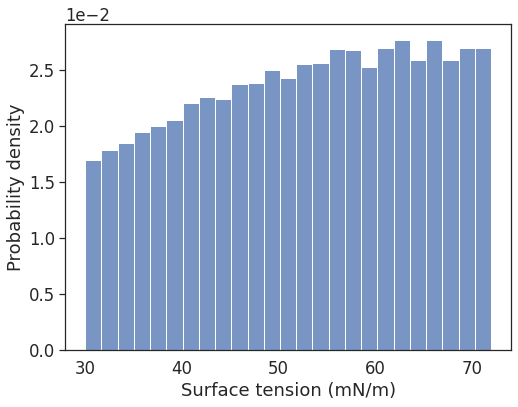

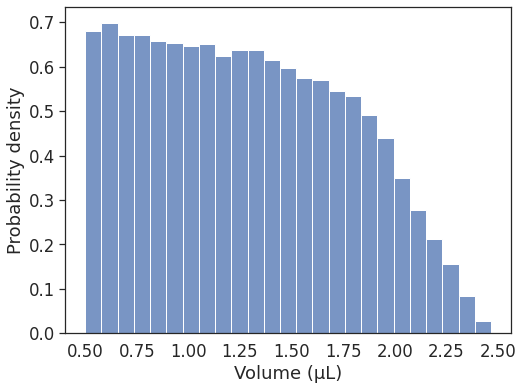

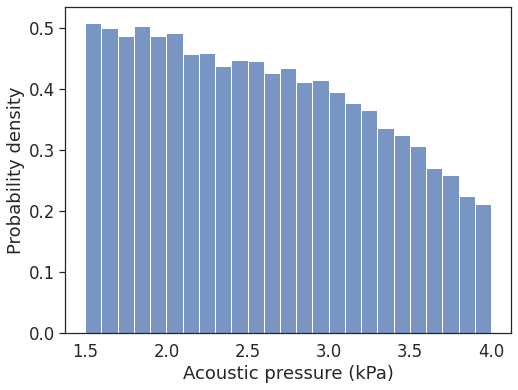

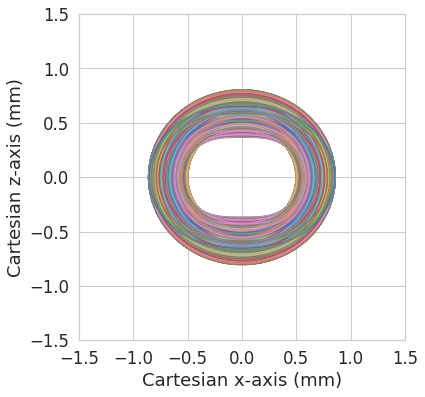

In [5]:
#New data distribution

dataset=final_dataset.copy()
# dataset.to_csv('/content/drive/My Drive/DropLev/Dataset/In_Silico/raw_dataset_same_theta_after_conditions_900points_more_compr.csv', ';', index=False)


savefig=False
path=str('/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/data_distribution/')
sampling=900

sns.set_theme(style='ticks', font_scale=1.5)

plt.figure(figsize=(8,6))
sns.histplot(dataset.ST, kde=False, bins=25, stat="density")
plt.xlabel('Surface tension (mN/m)')
plt.ylabel('Probability density')
plt.tick_params(bottom = False)
plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
if savefig==True:
  plt.savefig(path+'ST_theory_after_svg', dpi=300, format='svg')
  plt.savefig(path+'ST_theory_after_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
sns.histplot(dataset.vol, kde=False, bins=25, stat="density")
plt.xlabel('Volume (μL)')
plt.ylabel('Probability density')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'Volume_theory_after_svg', dpi=300, format='svg')
  plt.savefig(path+'Volume_theory_after_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
sns.histplot(dataset.Ps/1000, kde=False, bins=25, stat="density")
plt.xlabel('Acoustic pressure (kPa)')
plt.ylabel('Probability density')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'Ps_theory_after_svg', dpi=300, format='svg')
  plt.savefig(path+'Ps_theory_after_png', dpi=300, format='png')


sns.set_theme(style='whitegrid', font_scale=1.5)

fig, ax = plt.subplots(figsize=(8,6))
plt.xlabel('Cartesian x-axis (mm)')
plt.ylabel('Cartesian z-axis (mm)')
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
for j in range(len(dataset)):
  try:
    x,y=pol2cart_theta(np.asarray(dataset.iloc[j, 0:sampling]), np.asarray(dataset.iloc[j, sampling:2*sampling]))
    plt.plot(x, y)
  except:
    j=j+1
if savefig==True:
  plt.savefig(path+'contours_theory_after_svg', dpi=300, format='svg')
  plt.savefig(path+'contours_theory_after_png', dpi=300, format='png')


# final_dataset.to_csv('/content/drive/My Drive/DropLev/Dataset/insilico_dataset_after_conditions.csv', ';', index=False)
# raw_dataset.to_csv('/content/drive/My Drive/DropLev/Dataset/insilico_raw_dataset.csv', ';', index=False)




#### Drop contour points

In [6]:
#Choosing 175 points with constant phi

sampling=900
points=175
new_phi=np.linspace(-3.13, 3.13, points)

new_rho=[]

### Interpolate to find all the radius for specific theta
for k in range(len(dataset)):
  x, y = pol2cart_theta(dataset.iloc[k, 0:sampling].values, dataset.iloc[k, sampling:2*sampling].values)
  rho, phi=cart2pol(x, y)
  contour_interp=interp1d(phi, rho, kind='slinear')
  new_rho.append(contour_interp(new_phi))

theta = []
theta_array = []
features = pd.DataFrame()

rho_n=[]

for k in range(points):
  rho_n.append(str('row_%d' %k))

features[rho_n]=new_rho

# for k in range(points):
#   theta.append(str('theta_%d' %k))

# x, y = pol2cart(new_rho, new_phi)
# theta_array = azimuth(x, y)

# features[theta] = theta_array

features_DF=pd.concat([features, dataset.iloc[:, 2*sampling:]], axis=1)

AR=features_DF.pop('AR')
radius=features_DF.pop('radius')
vol=features_DF.pop('vol')
features_DF.tail()


dataset=features_DF.copy()

dataset.tail()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


,row_0,row_1,row_2,row_3,row_4,row_5,row_6,row_7,row_8,row_9,...,row_167,row_168,row_169,row_170,row_171,row_172,row_173,row_174,Ps,ST
50423,0.720853,0.720616,0.720093,0.719286,0.718199,0.716837,0.715208,0.713321,0.711185,0.708811,...,0.713322,0.715209,0.716837,0.718198,0.719285,0.720093,0.720617,0.720854,2440.778163,46.934689
50424,0.686396,0.686239,0.685892,0.685357,0.684636,0.683733,0.682653,0.681401,0.679984,0.678410,...,0.681402,0.682653,0.683733,0.684636,0.685357,0.685892,0.686240,0.686397,2409.976323,63.571301
50425,0.787369,0.787164,0.786711,0.786013,0.785072,0.783894,0.782484,0.780851,0.779002,0.776948,...,0.780851,0.782484,0.783893,0.785071,0.786012,0.786711,0.787165,0.787370,2246.471091,59.265300
50426,0.588555,0.588348,0.587890,0.587183,0.586232,0.585039,0.583613,0.581961,0.580090,0.578012,...,0.581961,0.583614,0.585039,0.586231,0.587183,0.587890,0.588348,0.588556,3058.148777,50.762339
50427,0.692031,0.691883,0.691555,0.691050,0.690369,0.689515,0.688495,0.687312,0.685974,0.684487,...,0.687313,0.688495,0.689515,0.690368,0.691049,0.691555,0.691883,0.692032,1656.011831,32.620363


### Check contours

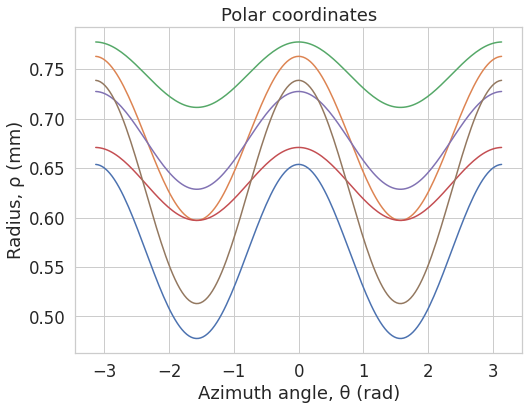

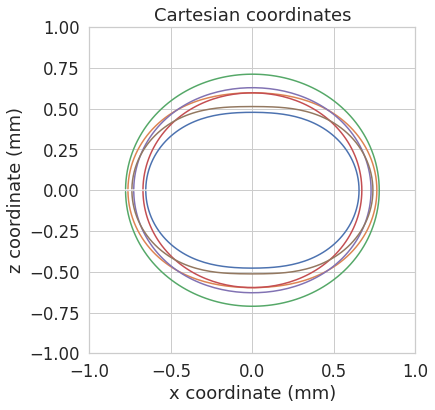

In [ ]:
n=0
rand_cont=np.array([0, 1500, 3000, 5000, 6000, 7500])
savefig=False
path=str('/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/')

if dataset.shape[1] > 400:
  points=900
  phi=dataset.iloc[n, points:2*points]
elif dataset.shape[1]<200:
  points=175
  phi=new_phi

plt.figure(figsize=(8,6))
plt.title('Polar coordinates')
for n in rand_cont:
  plt.plot(phi, dataset.iloc[n, 0:points])
plt.ylabel('Radius, ρ (mm)')
plt.xlabel('Azimuth angle, θ (rad)')
if savefig==True:
  plt.savefig(path+'polar_contours_before_norm_svg', dpi=300, format='svg')
  plt.savefig(path+'polar_contours_before_norm_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
plt.title('Cartesian coordinates')
for i in rand_cont:
  x, y=pol2cart(dataset.iloc[i, 0:points].values, phi)
  plt.plot(x, y)
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
plt.xlabel('x coordinate (mm)')
plt.ylabel('z coordinate (mm)')
if savefig==True:
  plt.savefig(path+'Cart_contours_before_norm_svg', dpi=300, format='svg')
  plt.savefig(path+'Cart_contours_before_norm_png', dpi=300, format='png')


### Shuffle the data

In [7]:
dataset=shuffle(dataset, random_state=0)

dataset=dataset.reset_index()
dataset.pop('index')
dataset.tail()

,row_0,row_1,row_2,row_3,row_4,row_5,row_6,row_7,row_8,row_9,...,row_167,row_168,row_169,row_170,row_171,row_172,row_173,row_174,Ps,ST
50423,0.704663,0.704567,0.704356,0.704031,0.703593,0.703043,0.702386,0.701625,0.700763,0.699805,...,0.701625,0.702386,0.703043,0.703592,0.704031,0.704356,0.704568,0.704663,1724.775618,59.380928
50424,0.632696,0.632487,0.632025,0.631313,0.630354,0.629152,0.627715,0.626049,0.624164,0.622070,...,0.626050,0.627715,0.629152,0.630353,0.631313,0.632025,0.632488,0.632697,3337.331091,71.977815
50425,0.811638,0.811482,0.811138,0.810607,0.809892,0.808996,0.807924,0.806682,0.805276,0.803714,...,0.806682,0.807924,0.808996,0.809891,0.810607,0.811138,0.811483,0.811639,1913.779293,63.047806
50426,0.681748,0.681640,0.681402,0.681036,0.680542,0.679923,0.679182,0.678324,0.677353,0.676275,...,0.678325,0.679182,0.679922,0.680541,0.681035,0.681402,0.681641,0.681748,1528.620644,37.755653
50427,0.708404,0.707933,0.706892,0.705287,0.703125,0.700415,0.697175,0.693420,0.689170,0.684448,...,0.693422,0.697176,0.700415,0.703123,0.705286,0.706892,0.707935,0.708406,3132.627025,32.270707


### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [8]:
train_data = dataset.sample(frac=0.8,random_state=1)
test_data = dataset.drop(train_data.index)

train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

### Min-Max transformation

The range values of the features is changed into 0 to 1

In [9]:
#Scalling training dataset
new_df_train=MinMaxTransformTrain(train_data, points=175)
new_df_train.tail()

,row_0,row_1,row_2,row_3,row_4,row_5,row_6,row_7,row_8,row_9,...,row_165,row_166,row_167,row_168,row_169,row_170,row_171,row_172,row_173,row_174
40337,0.839875,0.839257,0.837892,0.835787,0.832952,0.829398,0.825149,0.820225,0.814652,0.808459,...,0.808458,0.814652,0.820227,0.825150,0.829398,0.832949,0.835785,0.837892,0.839259,0.839877
40338,0.496303,0.495647,0.494198,0.491962,0.488952,0.485178,0.480666,0.475437,0.469519,0.462943,...,0.462942,0.469520,0.475440,0.480667,0.485178,0.488949,0.491960,0.494198,0.495650,0.496306
40339,0.413989,0.413585,0.412694,0.411318,0.409466,0.407144,0.404367,0.401150,0.397509,0.393463,...,0.393462,0.397510,0.401152,0.404368,0.407144,0.409464,0.411317,0.412694,0.413587,0.413991
40340,0.772804,0.772323,0.771260,0.769622,0.767415,0.764649,0.761341,0.757509,0.753171,0.748351,...,0.748350,0.753172,0.757511,0.761343,0.764649,0.767413,0.769620,0.771261,0.772325,0.772806
40341,0.411204,0.410826,0.409991,0.408703,0.406969,0.404795,0.402195,0.399183,0.395773,0.391985,...,0.391984,0.395774,0.399184,0.402196,0.404794,0.406967,0.408702,0.409991,0.410827,0.411205


In [10]:
#Scalling test dataset based on training dataset
new_df_test=MinMaxTransformTest(test_data, train_data, points=175)
new_df_test.tail()

,row_0,row_1,row_2,row_3,row_4,row_5,row_6,row_7,row_8,row_9,...,row_165,row_166,row_167,row_168,row_169,row_170,row_171,row_172,row_173,row_174
10081,0.903407,0.903000,0.902100,0.900712,0.898842,0.896499,0.893697,0.890450,0.886775,0.882692,...,0.882691,0.886776,0.890452,0.893698,0.896499,0.898840,0.900711,0.902100,0.903001,0.903409
10082,0.677999,0.677310,0.675787,0.673438,0.670275,0.666311,0.661569,0.656076,0.649858,0.642948,...,0.642947,0.649859,0.656078,0.661571,0.666310,0.670272,0.673437,0.675788,0.677313,0.678002
10083,0.690302,0.689261,0.686958,0.683408,0.678626,0.672633,0.665465,0.657160,0.647761,0.637316,...,0.637314,0.647762,0.657164,0.665468,0.672631,0.678621,0.683405,0.686959,0.689264,0.690307
10084,0.641303,0.641083,0.640598,0.639849,0.638841,0.637577,0.636066,0.634315,0.632334,0.630132,...,0.630132,0.632334,0.634316,0.636067,0.637577,0.638840,0.639848,0.640598,0.641084,0.641304
10085,0.695708,0.694746,0.692622,0.689345,0.684933,0.679402,0.672788,0.665125,0.656451,0.646813,...,0.646811,0.656452,0.665129,0.672791,0.679401,0.684928,0.689343,0.692622,0.694750,0.695712


In [11]:
points=175

if train_data.shape[1]>2*points:
  stats = train_data.iloc[:, 2*points:].describe() 
else:
  stats = train_data.iloc[:, points:].describe() 

stats = stats.transpose()
stats

,count,mean,std,min,25%,50%,75%,max
Ps,40342.0,2597.807250,686.920095,1500.007009,2003.218161,2549.140102,3148.926445,3999.981034
ST,40342.0,52.495811,11.789017,30.000614,42.740540,53.123200,62.672681,71.998954


In [12]:
if train_data.shape[1]>2*points:
  normed_train_data_rest = min_max_norm(train_data.iloc[:, 2*points:]) #iloc[:, 2*points:]
  normed_test_data_rest = min_max_norm(test_data.iloc[:, 2*points:])   #iloc[:, 2*points:]
else:
  normed_train_data_rest = min_max_norm(train_data.iloc[:, points:]) #iloc[:, 2*points:]
  normed_test_data_rest = min_max_norm(test_data.iloc[:, points:])   #iloc[:, 2*points:]

In [13]:
#Putting scalled train dataset together

normed_train_data = new_df_train.copy()
normed_train_data['Ps'] = normed_train_data_rest.Ps
normed_train_data['ST'] = normed_train_data_rest.ST

normed_train_data.tail()

,row_0,row_1,row_2,row_3,row_4,row_5,row_6,row_7,row_8,row_9,...,row_167,row_168,row_169,row_170,row_171,row_172,row_173,row_174,Ps,ST
40337,0.839875,0.839257,0.837892,0.835787,0.832952,0.829398,0.825149,0.820225,0.814652,0.808459,...,0.820227,0.825150,0.829398,0.832949,0.835785,0.837892,0.839259,0.839877,0.637988,0.955758
40338,0.496303,0.495647,0.494198,0.491962,0.488952,0.485178,0.480666,0.475437,0.469519,0.462943,...,0.475440,0.480667,0.485178,0.488949,0.491960,0.494198,0.495650,0.496306,0.577247,0.021021
40339,0.413989,0.413585,0.412694,0.411318,0.409466,0.407144,0.404367,0.401150,0.397509,0.393463,...,0.401152,0.404368,0.407144,0.409464,0.411317,0.412694,0.413587,0.413991,0.792156,0.812529
40340,0.772804,0.772323,0.771260,0.769622,0.767415,0.764649,0.761341,0.757509,0.753171,0.748351,...,0.757511,0.761343,0.764649,0.767413,0.769620,0.771261,0.772325,0.772806,0.403697,0.588313
40341,0.411204,0.410826,0.409991,0.408703,0.406969,0.404795,0.402195,0.399183,0.395773,0.391985,...,0.399184,0.402196,0.404794,0.406967,0.408702,0.409991,0.410827,0.411205,0.356635,0.057726


In [14]:
#Putting scalled test dataset together

normed_test_data = new_df_test.copy()
normed_test_data['Ps'] = normed_test_data_rest.Ps
normed_test_data['ST'] = normed_test_data_rest.ST

normed_test_data.tail()

,row_0,row_1,row_2,row_3,row_4,row_5,row_6,row_7,row_8,row_9,...,row_167,row_168,row_169,row_170,row_171,row_172,row_173,row_174,Ps,ST
10081,0.903407,0.903000,0.902100,0.900712,0.898842,0.896499,0.893697,0.890450,0.886775,0.882692,...,0.890452,0.893698,0.896499,0.898840,0.900711,0.902100,0.903001,0.903409,0.214653,0.576340
10082,0.677999,0.677310,0.675787,0.673438,0.670275,0.666311,0.661569,0.656076,0.649858,0.642948,...,0.656078,0.661571,0.666310,0.670272,0.673437,0.675788,0.677313,0.678002,0.614664,0.341452
10083,0.690302,0.689261,0.686958,0.683408,0.678626,0.672633,0.665465,0.657160,0.647761,0.637316,...,0.657164,0.665468,0.672631,0.678621,0.683405,0.686959,0.689264,0.690307,0.906110,0.275340
10084,0.641303,0.641083,0.640598,0.639849,0.638841,0.637577,0.636066,0.634315,0.632334,0.630132,...,0.634316,0.636067,0.637577,0.638840,0.639848,0.640598,0.641084,0.641304,0.011446,0.184651
10085,0.695708,0.694746,0.692622,0.689345,0.684933,0.679402,0.672788,0.665125,0.656451,0.646813,...,0.665129,0.672791,0.679401,0.684928,0.689343,0.692622,0.694750,0.695712,0.653055,0.054052


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [15]:
train_labels = normed_train_data.pop('ST')
test_labels = normed_test_data.pop('ST')

## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [16]:
sseed=10

def build_model(sseed=sseed):
  seed(sseed)
  tf.random.set_seed(sseed)
  model = keras.Sequential([
    layers.Dense(50, activation=tf.nn.swish, input_shape=[len(normed_train_data.keys())]), #kernel_regularizer='l2', 
    layers.Dense(40, activation=tf.nn.softplus),
    layers.Dense(30, activation=tf.nn.swish),
    layers.Dense(20, activation=tf.nn.softplus),
    layers.Dense(15, activation=tf.nn.swish),
    layers.Dense(10, activation=tf.nn.softplus),
    layers.Dense(5, activation=tf.nn.swish),
    layers.Dense(1)
  ])

  optimizer = get_optimizer() # tf.keras.optimizers.Adam(learning_rate=0.001) #RMSprop(0.0001)
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def get_optimizer():
  return tf.keras.optimizers.Adam()

In [17]:
model = build_model(sseed=sseed)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                8850      
                                                                 
 dense_1 (Dense)             (None, 40)                2040      
                                                                 
 dense_2 (Dense)             (None, 30)                1230      
                                                                 
 dense_3 (Dense)             (None, 20)                620       
                                                                 
 dense_4 (Dense)             (None, 15)                315       
                                                                 
 dense_5 (Dense)             (None, 10)                160       
                                                                 
 dense_6 (Dense)             (None, 5)                 5


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [19]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.28715122],
       [0.2882387 ],
       [0.28638178],
       [0.28674173],
       [0.2882246 ],
       [0.2866734 ],
       [0.2848736 ],
       [0.28690335],
       [0.2852951 ],
       [0.28878137]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [20]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0, restore_best_weights=True)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])



....................................................................................................
.......................................

Visualize the model's training progress using the stats stored in the `history` object.

In [21]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail() 

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
134,0.000126,0.006344,0.000126,0.000008,0.002150,0.000008,134
135,0.000068,0.004745,0.000068,0.000197,0.010353,0.000197,135
136,0.000140,0.007768,0.000140,0.000019,0.003083,0.000019,136
137,0.000106,0.006066,0.000106,0.000012,0.002398,0.000012,137
138,0.000137,0.005900,0.000137,0.000004,0.001605,0.000004,138


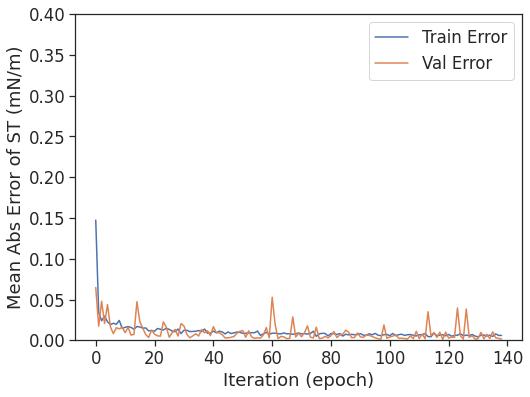

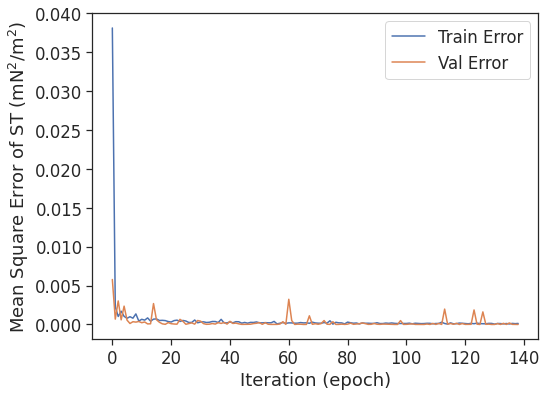

In [ ]:
def plot_history(hist, savefig=False, path='/content/drive/My Drive/DropLev/Dataset/In_Silico/'):
  sns.set_theme(style='ticks', font_scale=1.5)

  plt.figure(figsize=(8,6))
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Abs Error of ST (mN/m)')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,0.4])
  plt.legend()
  if savefig==True:
    plt.savefig(path+'training_outcome_MAE_png', dpi=300, format='png')
    plt.savefig(path+'training_outcome_MAE_svg', dpi=300, format='svg')


  plt.figure(figsize=(8,6))
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Square Error of ST (mN$^2$/m$^2$)')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  # plt.ylim([0,0.05])
  plt.legend()
  if savefig==True:
    plt.savefig(path+'training_outcome_MSE_png', dpi=300, format='png')
    plt.savefig(path+'training_outcome_MSE_svg', dpi=300, format='svg')

  plt.show()


plot_history(hist, savefig=False, path='/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/training_outcome/')

The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

### Make predictions

Finally, predict ST values using data in the testing set:

In [ ]:
## Re-scale target feature
def rescaling(target, min=stats.loc['ST']['min'], max=stats.loc['ST']['max']):
  target=np.asarray(target)
  return (max-min)*(target)+min

test_predictions = model.predict(normed_test_data).flatten()
train_predictions = model.predict(normed_train_data).flatten()

ST_real_test=rescaling(test_labels)
ST_pred_test=rescaling(test_predictions)

ST_real_train=rescaling(train_labels)
ST_pred_train=rescaling(train_predictions)  

#Re-scalling check:
# plt.figure(figsize=(8,6))
# plt.scatter(range(len(test_labels)), test_labels)
# plt.ylabel('Normalizaed surface tension')
# plt.xlabel('Instances')

# plt.figure(figsize=(8,6))
# plt.scatter(range(len(ST_real_test)), ST_real_test)
# plt.ylabel('Surface tension (mN/m)')
# plt.xlabel('Instances')

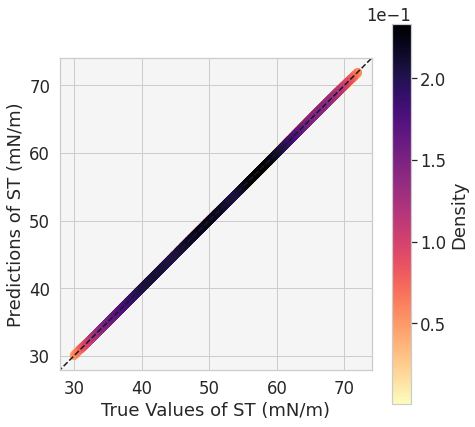

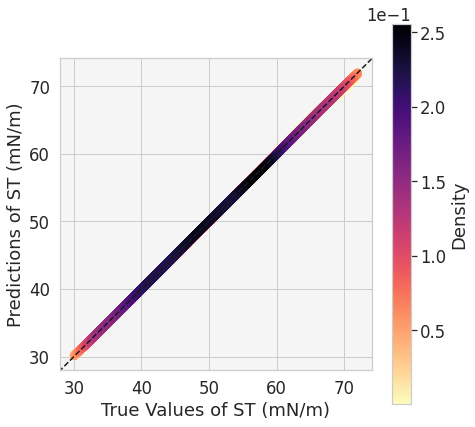

In [ ]:

savefig=False
path='/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/training_outcome/'

sns.set_theme(style='whitegrid', font_scale=1.5)

density_scatter(ST_real_test, ST_pred_test, title=None)
plt.plot([-100, 100], [-100, 100], '--k')
if savefig==True:
  plt.savefig(path+'error_plot_test_data_png', dpi=300, format='png')
  plt.savefig(path+'error_plot_test_data_svg', dpi=300, format='svg')


density_scatter(ST_real_train, ST_pred_train, title=None)
plt.plot([-100, 100], [-100, 100], '--k')
if savefig==True:
  plt.savefig(path+'error_plot_training_data_png', dpi=300, format='png')
  plt.savefig(path+'error_plot_training_data_svg', dpi=300, format='svg')


Seriously?

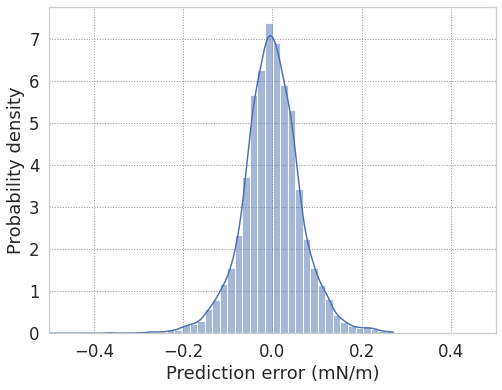

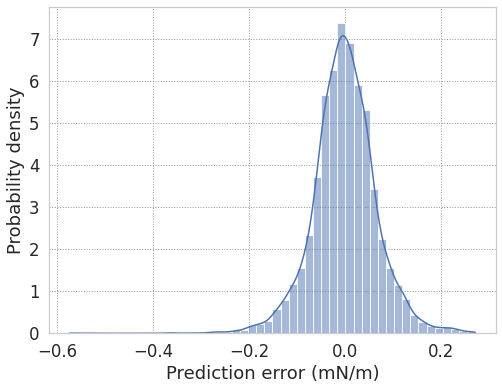

In [ ]:
from tensorflow.python.ops.gen_math_ops import truncate_div
error_test = ST_pred_test - ST_real_test

savefig=False
path='/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/training_outcome/'
sns.set_theme(style='whitegrid', font_scale=1.5)
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})

plt.figure(figsize=(8,6))
sns.histplot(error_test, bins = 50, kde=True, stat="density")
plt.xlabel("Prediction error (mN/m)")
_ = plt.ylabel("Probability density")
plt.xlim(-0.5, 0.5)
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'error_distrib_test_data_lim_png', dpi=300, format='png')
  plt.savefig(path+'error_distrib_test_data_lim_svg', dpi=300, format='svg')

plt.show()


plt.figure(figsize=(8,6))
sns.histplot(error_test, bins = 50, kde=True, stat="density")
plt.xlabel("Prediction error (mN/m)")
_ = plt.ylabel("Probability density")
plt.tick_params(bottom = False)
# plt.xticks(np.arange(-0.1, 0.15, step=0.05), [-0.1 , -0.05,  0.  ,  0.05,  0.1])
if savefig==True:
  plt.savefig(path+'error_distrib_test_data_png', dpi=300, format='png')
  plt.savefig(path+'error_distrib_test_data_svg', dpi=300, format='svg')

plt.show()

In [ ]:
#Confidence:

error_test_test=np.asarray(error_test)

rows_05=error_test_test[(error_test_test >= -0.5) & (error_test_test <= 0.5)]
rows_1=error_test_test[(error_test_test >= -1) & (error_test_test <= 1)]
rows_2=error_test_test[(error_test_test >= -2) & (error_test_test <= 2)]

mae=sum(abs(error_test_test))/len(error_test_test)
print('Confidence for error '+u"\u00B1"+' 0.5 mN/m: %.2f' %int(len(rows_05)/len(error_test)*100)+ ' %')

print('Confidence for error '+u"\u00B1"+' 1 mN/m: %.2f' %int(len(rows_1)/len(error_test)*100)+ ' %')

print('Confidence for error '+u"\u00B1"+' 2 mN/m: %.2f' %int(len(rows_2)/len(error_test)*100)+ ' %')

print('Mean Absolute error: %.2f mN/m' %mae)

Confidence for error ± 0.5 mN/m: 99.00 %
Confidence for error ± 1 mN/m: 100.00 %
Confidence for error ± 2 mN/m: 100.00 %
Mean Absolute error: 0.05 mN/m


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

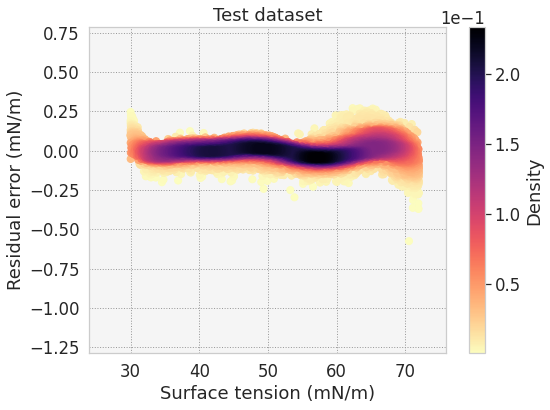

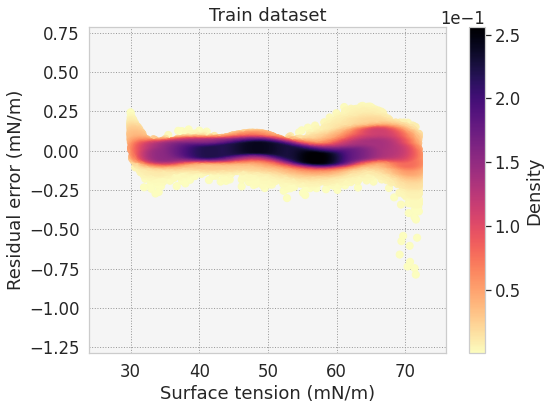

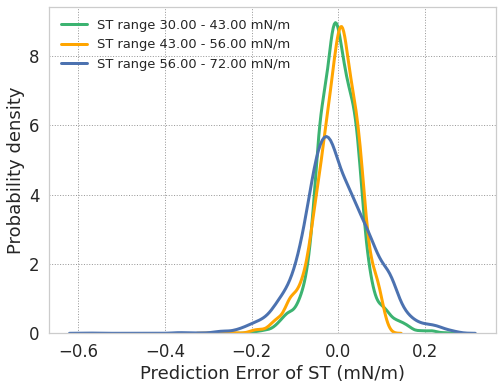

In [ ]:
error_test = ST_pred_test - ST_real_test
error_train = ST_pred_train - ST_real_train

path='/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/training_outcome/'
savefig=False

density_scatter(ST_real_test, error_test, title='Test dataset',  eq_sq=False, figsize=(8,6))
plt.ylim(min(error_train)-0.5, max(error_train)+0.5)
plt.gca().invert_xaxis()
plt.xlim(25-1, 75+1)
plt.ylabel('Residual error (mN/m)')
plt.xlabel('Surface tension (mN/m)')
if savefig==True:
  plt.savefig(path+'error_Vs_ST_test_data_png', dpi=300, format='png')
  plt.savefig(path+'error_Vs_ST_test_data_svg', dpi=300, format='svg')


density_scatter(ST_real_train, error_train, title='Train dataset', eq_sq=False, figsize=(8,6))
plt.ylim(min(error_train)-0.5, max(error_train)+0.5)
plt.gca().invert_xaxis()
plt.xlim(25-1, 75+1)
plt.ylabel('Residual error (mN/m)')
plt.xlabel('Surface tension (mN/m)')
if savefig==True:
  plt.savefig(path+'error_Vs_ST_training_data_png', dpi=300, format='png')
  plt.savefig(path+'error_Vs_ST_training_data_svg', dpi=300, format='svg')



check_test_df=pd.DataFrame(data={'True_values': ST_real_test, 'Predictions': ST_pred_test})

sorted_st=check_test_df.sort_values(by=['True_values'], ascending=False)

step=int((max(sorted_st.True_values)-min(sorted_st.True_values))/3)

trial_1=sorted_st.loc[(sorted_st['True_values'] >= min(sorted_st.True_values)) & (sorted_st['True_values'] <= (min(sorted_st.True_values)+step))]
trial_2=sorted_st.loc[(sorted_st['True_values'] >= (min(sorted_st.True_values)+step)) & (sorted_st['True_values'] <= (min(sorted_st.True_values)+step*2))]
trial_3=sorted_st.loc[(sorted_st['True_values'] >= (min(sorted_st.True_values)+step*2)) & (sorted_st['True_values'] <= max(sorted_st.True_values))]

thickness=3

plt.figure(figsize=(8,6))
sns.distplot(trial_1.Predictions-trial_1.True_values, hist=False, kde=True, kde_kws=dict(linewidth=thickness), color='mediumseagreen', label='ST range %.2f - %.2f mN/m' %(min(sorted_st.True_values), min(sorted_st.True_values)+step))
sns.distplot(trial_2.Predictions-trial_2.True_values, hist=False, kde=True, kde_kws=dict(linewidth=thickness), color='orange', label='ST range %.2f - %.2f mN/m' %(min(sorted_st.True_values)+step, min(sorted_st.True_values)+step*2))
sns.distplot(trial_3.Predictions-trial_3.True_values, hist=False, kde=True, kde_kws=dict(linewidth=thickness), label='ST range %.2f - %.2f mN/m' %(min(sorted_st.True_values)+step*2, max(sorted_st.True_values)))
plt.ylabel("Probability density")
plt.xlabel("Prediction Error of ST (mN/m)")
plt.legend(frameon=False, prop={"size":13})
if savefig==True:
  plt.savefig(path+'test_data_error_distr_steps_png', dpi=300, format='png')
  plt.savefig(path+'test_data_error_distr_steps_svg', dpi=300, format='svg')


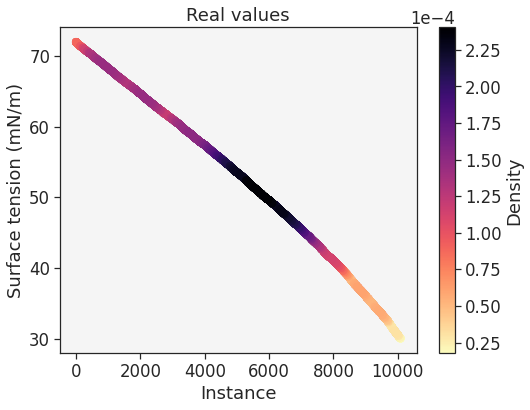

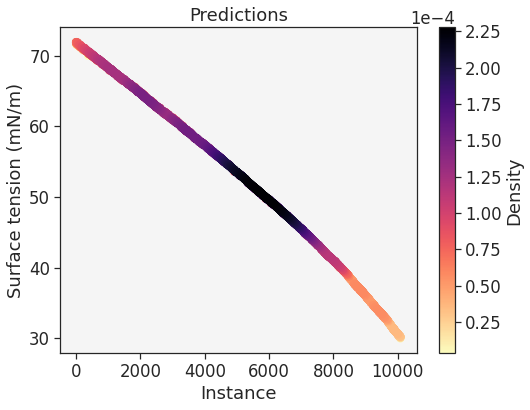

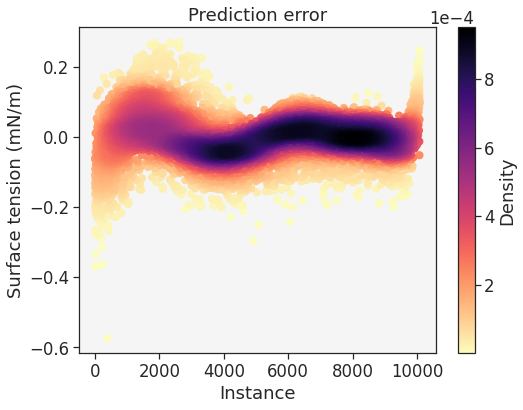

In [ ]:
path='/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/training_outcome/'
savefig=False

check_test_df=pd.DataFrame(data={'True_values': ST_real_test, 'Predictions': ST_pred_test})

sorted_st=check_test_df.sort_values(by=['True_values'], ascending=False)

sns.set_theme(style='ticks', font_scale=1.5)


density_scatter(range(len(sorted_st)), sorted_st.True_values,title='Real values',  eq_sq=False, figsize=(8,6))
plt.xlabel('Instance')
plt.ylabel('Surface tension (mN/m)')
if savefig==True:
  plt.savefig(path+'ST_Vs_instances_real_test_data_png', dpi=300, format='png')
  plt.savefig(path+'ST_Vs_instances_real_test_data_svg', dpi=300, format='svg')


density_scatter(range(len(sorted_st)), sorted_st.Predictions, title='Predictions',  eq_sq=False, figsize=(8,6))
plt.xlabel('Instance')
plt.ylabel('Surface tension (mN/m)')
if savefig==True:
  plt.savefig(path+'ST_Vs_instances_pred_test_data_png', dpi=300, format='png')
  plt.savefig(path+'ST_Vs_instances_pred_test_data_svg', dpi=300, format='svg')

density_scatter(range(len(sorted_st)), sorted_st.Predictions-sorted_st.True_values,title='Prediction error',  eq_sq=False, figsize=(8,6))
plt.xlabel('Instance')
plt.ylabel('Surface tension (mN/m)')
if savefig==True:
  plt.savefig(path+'ST_Vs_instances_pred_error_test_data_png', dpi=300, format='png')
  plt.savefig(path+'ST_Vs_instances_pred_error_test_data_svg', dpi=300, format='svg')



### Dummy regressor

In [23]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error

def rescaling(target, min=stats.loc['ST']['min'], max=stats.loc['ST']['max']):
  target=np.asarray(target)
  return (max-min)*(target)+min


m = DummyRegressor()
cvr = cross_validate(m, normed_train_data, train_labels, scoring='neg_mean_squared_error')
m.fit(normed_train_data, train_labels)
predicted = m.predict(normed_test_data).flatten()

ST_real_test_dummy=rescaling(test_labels)
ST_pred_test_dummy=rescaling(predicted)

MAE = mean_absolute_error(ST_real_test_dummy, ST_pred_test_dummy)
MSE = mean_squared_error(ST_real_test_dummy, ST_pred_test_dummy)


print("Cross validation average negative mean squared error: %.3f" %(np.mean(cvr['test_score'])))
print('Mean absolute error on test data: %.3f' %MAE)
print('Mean squared error on test data: %.3f' %MSE)

Cross validation average negative mean squared error: -0.079
Mean absolute error on test data: 10.110
Mean squared error on test data: 138.100


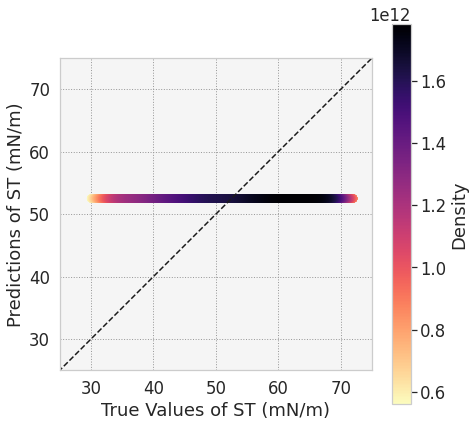

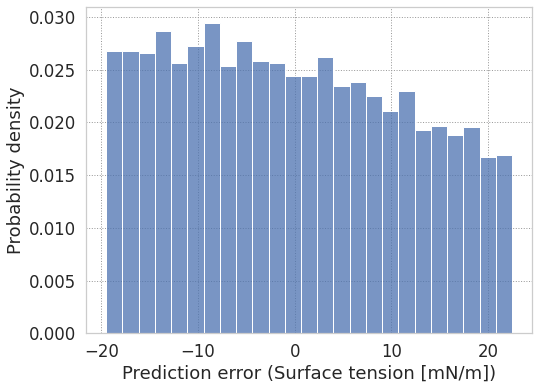

In [25]:
path='/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/'
savefig=True
colours='magma_r'

density_scatter(ST_real_test_dummy, ST_pred_test_dummy, colours=colours)
_ = plt.plot([-100, 100], [-100, 100], '--k')
plt.xlim(25, 75)
plt.ylim(25, 75)
if savefig==True:
  plt.savefig(path+'DummyRegressor_error_plot_svg', dpi=300, format='svg')
  plt.savefig(path+'DummyRegressor_error_plot_png', dpi=300, format='png')


sns.set_theme(style='whitegrid', font_scale=1.5)
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})

plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(ST_pred_test_dummy-ST_real_test_dummy, kde=False, bins=25, stat="density")
plt.xlabel('Prediction error (Surface tension [mN/m])')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'DummyRegressor_error_distr_svg', dpi=300, format='svg')
  plt.savefig(path+'DummyRegressor_error_distr_png', dpi=300, format='png')

### Saving

In [ ]:
#Save prediction outcome in a csv file
error_test = ST_pred_test - ST_real_test
error_train = ST_pred_train - ST_real_train

outcome_train=pd.DataFrame(data=np.array([ST_real_train, ST_pred_train]).T, columns=['Train_labels', 'Train_pred'])
outcome_test=pd.DataFrame(data=np.array([ST_real_test, ST_pred_test]).T, columns=[ 'Test_labels', 'Test_pred'])

date=str('20220927')

model_No=1

data_No=50428
ST_min=30
ST_max=72
vol_min=0.5
vol_max=2.5
Ps_min=1500
Ps_max=4000
error=0.05

path='/content/drive/My Drive/DropLev/for_draft/In_silico/'
filename=str('data_%d_ST_%.2f_%.2f_vol_%.2f_%.2f_Ps_%d_%d_model_%d_MAE_%.2f_%s.csv' %(data_No, ST_min, ST_max, vol_min, vol_max, Ps_min, Ps_max, model_No, error, date))
!mkdir -p '/content/drive/My Drive/DropLev/for_draft/In_silico/' #Ceates a folder named "MachineLearningModels"
outcome_train.to_csv(path+'train_out_'+filename, index=False)  #Saves the file
outcome_test.to_csv(path+'test_out_'+filename, index=False)  #Saves the file

hist.to_csv(path+'history_'+filename)


In [ ]:
#Save training dataset

train_data.to_csv(path+'training_dataset_eq_rho_'+filename)

When you are satisfied with the model and the accuracy continue from here:

Saving the model in a **SavedModel** format

In [ ]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
import os

In [ ]:
# Save the entire model as a SavedModel.
modelfilename=str('Model_data_%d_ST_%.2f_%.2f_vol_%.2f_%.2f_Ps_%d_%d_model_%d_MAE_%.2f_%s.csv' %(data_No, ST_min, ST_max, vol_min, vol_max, Ps_min, Ps_max, model_No, error, date))

# !mkdir -p '/content/drive/My Drive/DropLev/for_draft/In_silico/' #Ceates a folder named "MachineLearningModels"
model.save('/content/drive/My Drive/DropLev/for_draft/In_silico/'+modelfilename)  #Saves the file

### Feature importance

In [ ]:
from sklearn.utils import shuffle
from tensorflow.keras.models import load_model


path=str('/content/drive/My Drive/DropLev/for_draft/In_silico/')
date=str('20220927')
model_No=1
data_No=50428
ST_min=30
ST_max=72
vol_min=0.5
vol_max=2.5
Ps_min=1500
Ps_max=4000
error=0.05
filename=str(path+'Model_data_%d_ST_%.2f_%.2f_vol_%.2f_%.2f_Ps_%d_%d_model_%d_MAE_%.2f_%s.csv' %(data_No, ST_min, ST_max, vol_min, vol_max, Ps_min, Ps_max, model_No, error, date))

#Import trained model
model=load_model(filename)

#Define MAE from the original training
mae=0.05

#Define number of features/columns
featureNum=normed_test_data.shape[1]

#Define feature/column names
ColumnName=normed_test_data.columns

#Rescalling test labels
ST_real_test=rescaling(test_labels)

#Define a dictionary to save the error
error_test={}
MAE={}
Conf_05={}
Conf_1={}
Conf_2={}

for i in range(featureNum):
  feature=normed_test_data.iloc[:, i]

  for j in range(0, 99, 33):
    # seed(j)

    #Shuffle one feature j times
    shuffled_feature=shuffle(feature, random_state=j)
    #Reset the indexes of the new column
    shuffled_feature.reset_index(drop=True, inplace=True)

    #Copy the normalized test Dataframe into a new Dataframe
    shuffled_test=normed_test_data.copy()

    #Replace feature with shuffled feature
    shuffled_test[ColumnName[i]]=shuffled_feature

    #Predict on the test data with the shuffled feature
    test_predictions = model.predict(shuffled_test).flatten()

    #Rescalling test predictions with shuffled feature
    ST_pred_test=rescaling(test_predictions)

    error_test[i, j] = ST_real_test - ST_pred_test

    MAE[i, j]=sum(abs(error_test[i, j]))/len(error_test[i, j])-mae

    rows_05=error_test[i, j][(error_test[i, j] >= -0.5) & (error_test[i, j] <= 0.5)]
    rows_1=error_test[i, j][(error_test[i, j] >= -1) & (error_test[i, j] <= 1)]
    rows_2=error_test[i, j][(error_test[i, j] >= -2) & (error_test[i, j] <= 2)]

    Conf_05[i, j]=int(len(rows_05)/len(error_test[i, j])*100)
    Conf_1[i, j]=int(len(rows_1)/len(error_test[i, j])*100)
    Conf_2[i, j]=int(len(rows_2)/len(error_test[i, j])*100)






In [ ]:
trial=pd.DataFrame.from_dict(MAE, orient='index')

trial=np.asarray(trial, dtype=object)

j=0
Mean=[]
Min=[]
Max=[]
Std=[]
step=int(len(trial)/featureNum)
for i in range(featureNum):
  Mean.append(np.mean(trial[j:j+step]))
  Min.append(min(trial[j:j+step]))
  Max.append(max(trial[j:j+step]))
  Std.append(np.std(trial[j:j+step]))
  j=j+step



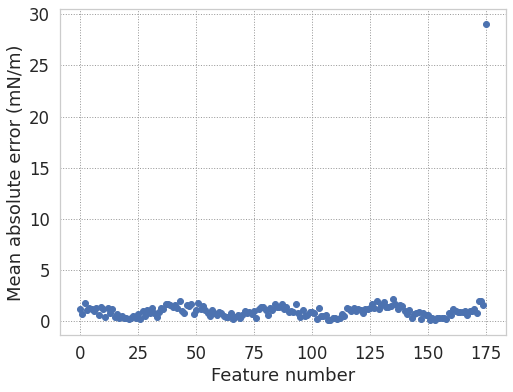

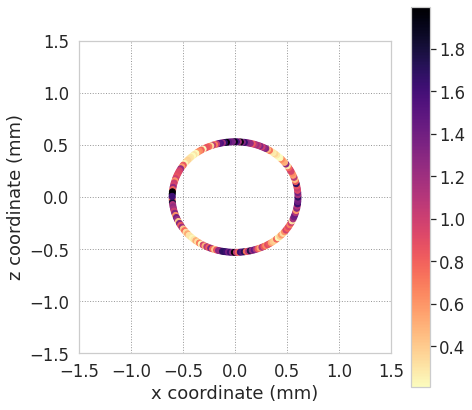

In [ ]:
import matplotlib
savefig=False
sns.set_theme(style='whitegrid', font_scale=1.5)
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})

# xticks=[0, 158, 174, 175, 249, 349, 350, 351]
# xticksnames=ColumnName[xticks]

plt.figure(figsize=(8, 6))
plt.plot(range(featureNum), Mean, 'o')
# plt.xticks(xticks, xticksnames, rotation=90)
plt.xlabel('Feature number')
plt.ylabel('Mean absolute error (mN/m)')
# plt.xlim(175, 349.5)
# plt.ylim(0.1, 0.2)
if savefig==True:
  plt.savefig(path+'features_Vs_MAE_theory_svg', dpi=300, format='svg')
  plt.savefig(path+'features_Vs_MAE_theory_png', dpi=300, format='png')


# theta=raw_dataset.iloc[:, 175:350]

# for i in range(80,160, 1):
#   theta.pop('theta_%d' %i)

z_min=min(Mean[0:95])
z_max=max(Mean[0:95])
fig, ax=plt.subplots(figsize=(7,7))
norm=matplotlib.colors.Normalize(z_min, z_max) #vmin=min(data.Z_center), vmax=max(data.Z_center)
x, y=pol2cart(test_data.iloc[1000, 0:175].values, new_phi)
im=plt.scatter(x,y, c=Mean[0:175], norm=norm, cmap='magma_r')
plt.colorbar(im, ax=ax)
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
plt.xlabel('x coordinate (mm)')
plt.ylabel('z coordinate (mm)')
if savefig==True:
  plt.savefig(path+'feature_importance_coloured_coords_theory_svg', dpi=300, format='svg')
  plt.savefig(path+'feature_importance_coloured_coords_theory_png', dpi=300, format='png')

# plt.figure()
# for i in range(featureNum):
#   plt.errorbar(x=i, y=Mean[i], yerr=(Max[i]-Min[i]))
# plt.ylim(0.7, 1.5)

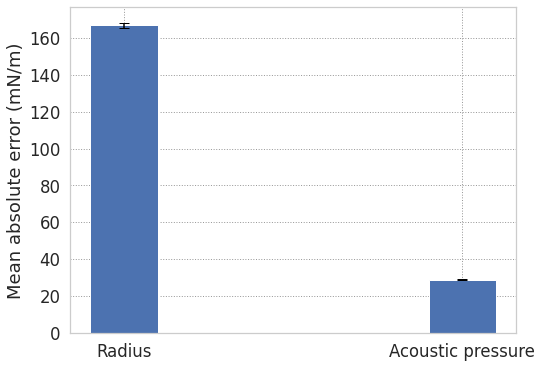

In [ ]:
sns.set_theme(style='whitegrid', font_scale=1.5)
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})

savefig=False

xlabels = ['Radius', 'Acoustic pressure']
y = np.array([sum(Mean[0:175]), Mean[175]])

error = [sum(Std[0:175]), Std[175]]


plt.figure(figsize=(8,6))
plt.bar(xlabels, y, yerr=error, ecolor='black', capsize=5, align='center', width=0.2)
# plt.xticks(xlabels)
# plt.xlabel("Feature")
_ = plt.ylabel("Mean absolute error (mN/m)")
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'feature_importance_error_bars_theory_svg', dpi=300, format='svg')
  plt.savefig(path+'feature_importance_error_bars_theory_png', dpi=300, format='png')


## Adding noise on the in-silico data

### Tilting 

In [ ]:
from scipy.stats import gaussian_kde
from matplotlib.colors import Normalize 
from matplotlib import cm
from sklearn.utils import shuffle

from numpy.random import seed

def MinMaxTransformTrain(train_dataset, points):

  max_rho=[]
  min_rho=[]
  # min_theta=[]
  # max_theta=[]
  for i in range(len(train_dataset)):
    max_rho.append(max(train_dataset.iloc[i, 0:points].values))
    min_rho.append(min(train_dataset.iloc[i, 0:points].values))
    # max_theta.append(max(train_dataset.iloc[i, points:2*points].values))
    # min_theta.append(min(train_dataset.iloc[i, points:2*points].values))

  # print(min(min_rho), max(max_rho), min(min_theta), max(max_theta))

  # Change the range of rho from 0 to 1

  OldMax= max(max_rho)
  OldMin=min(min_rho)

  NewValues_rho={}

  OldRange = (OldMax - OldMin)
  for i in range(len(train_dataset)):
    if (OldRange == 0):
        NewValue = OldMin
        NewValues_rho[i]=NewValue
    else:
        NewValue = (train_dataset.iloc[i, 0:points] - OldMin)/(OldMax-OldMin) 
        NewValues_rho[i]=NewValue

  # Change the range of theta from 0 to 1

  # OldMax= max(max_theta)
  # OldMin=min(min_theta)

  # NewValues_theta={}

  # OldRange = (OldMax - OldMin)
  # for i in range(len(train_dataset)):
  #   if (OldRange == 0):
  #       NewValue = OldMin
  #       NewValues_theta[i]=NewValue
  #   else:
  #       NewValue = (train_dataset.iloc[i, points:2*points] - OldMin)/(OldMax-OldMin) 
  #       NewValues_theta[i]=NewValue

  df_rho=pd.DataFrame.from_dict(NewValues_rho).T
  # df_theta=pd.DataFrame.from_dict(NewValues_theta).T

  # new_df=pd.concat([df_rho, df_theta], axis=1)

  return df_rho


def MinMaxTransformTest(test_dataset, train_dataset, points):

  max_rho=[]
  min_rho=[]
  # min_theta=[]
  # max_theta=[]
  for i in range(len(train_dataset)):
    max_rho.append(max(train_dataset.iloc[i, 0:points].values))
    min_rho.append(min(train_dataset.iloc[i, 0:points].values))
    # max_theta.append(max(train_dataset.iloc[i, points:2*points].values))
    # min_theta.append(min(train_dataset.iloc[i, points:2*points].values))

  # print(min(min_rho), max(max_rho), min(min_theta), max(max_theta))

  # Change the range of rho from 0 to 1

  OldMax= max(max_rho)
  OldMin=min(min_rho)

  NewValues_rho={}

  OldRange = (OldMax - OldMin)
  for i in range(len(test_dataset)):
    if (OldRange == 0):
        NewValue = OldMin
        NewValues_rho[i]=NewValue
    else:
        NewValue = (test_dataset.iloc[i, 0:points] - OldMin)/(OldMax-OldMin) 
        NewValues_rho[i]=NewValue

  # Change the range of theta from 0 to 1

  # OldMax= max(max_theta)
  # OldMin=min(min_theta)

  # NewValues_theta={}

  # OldRange = (OldMax - OldMin)
  # for i in range(len(test_dataset)):
  #   if (OldRange == 0):
  #       NewValue = OldMin
  #       NewValues_theta[i]=NewValue
  #   else:
  #       NewValue = (test_dataset.iloc[i, points:2*points] - OldMin)/(OldMax-OldMin) 
  #       NewValues_theta[i]=NewValue

  df_rho=pd.DataFrame.from_dict(NewValues_rho).T
  # df_theta=pd.DataFrame.from_dict(NewValues_theta).T

  # new_df=pd.concat([df_rho, df_theta], axis=1)

  return df_rho


def min_max_norm(x):
  return (x-stats['min'])/(stats['max']-stats['min'])

def build_model():
  seed(sseed)
  tf.random.set_seed(sseed)
  model = keras.Sequential([
    layers.Dense(50, activation=tf.nn.swish, input_shape=[len(normed_train_data.keys())]), #kernel_regularizer='l2', 
    layers.Dense(40, activation=tf.nn.softplus),
    layers.Dense(30, activation=tf.nn.swish),
    # layers.Dense(25, activation=tf.nn.swish),
    layers.Dense(20, activation=tf.nn.softplus),
    layers.Dense(15, activation=tf.nn.swish),
    layers.Dense(10, activation=tf.nn.softplus),
    layers.Dense(5, activation=tf.nn.swish),
    layers.Dense(1)
  ])

  optimizer = get_optimizer() # tf.keras.optimizers.Adam(learning_rate=0.001) #RMSprop(0.0001)
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def get_optimizer():
  return tf.keras.optimizers.Adam()


class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')



def plot_history(hist, savefig=False, figtype='svg', path='/content/drive/My Drive/DropLev/Dataset/In_Silico/'):
  sns.set_theme(style='ticks', font_scale=1.5)

  plt.figure(figsize=(8,6))
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Abs Error of ST (mN/m)')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,0.4])
  plt.legend()
  if savefig==True:
    plt.savefig(path+'training_outcome_MAE_'+figtype, dpi=300, format=figtype)

  plt.figure(figsize=(8,6))
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Square Error of ST (mN$^2$/m$^2$)')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  # plt.ylim([0,0.05])
  plt.legend()
  if savefig==True:
    plt.savefig(path+'training_outcome_MSE_'+figtype, dpi=300, format=figtype)
  plt.show()

def density_scatter(x, y, title=None, colours='magma_r', lim1=10, lim2=80, eq_sq=True, figsize=(7,7)):
  # Calculate the point density
  x=np.asarray(x)
  y=np.asarray(y)
  xy = np.vstack([x, y])
  z = gaussian_kde(xy)(xy)
  # Sort the points by density, so that the densest points are plotted last
  idx = z.argsort()
  x, y, z = x[idx], y[idx], z[idx]

  fig, ax = plt.subplots(figsize=figsize)
  ax.set_facecolor('whitesmoke')
  plt.title(title)
  im=ax.scatter(x, y, c=z, s=50, cmap=colours)
  plt.xlabel('True Values of ST (mN/m)')
  plt.ylabel('Predictions of ST (mN/m)')
  if eq_sq==True:
    plt.axis('equal')
    plt.axis('square')
  # plt.xlim([lim1, lim2])
  # plt.ylim([lim1, lim2])
  norm = Normalize(vmin = np.min(z), vmax = np.max(z))
  cbar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap=colours), ax=ax)
  cbar.ax.set_ylabel('Density')
  cbar.ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

def rescaling(target):
  min=stats.loc['ST']['min']
  max=stats.loc['ST']['max']
  target=np.asarray(target)
  return (max-min)*(target)+min

In [ ]:
#Tilting
sns.set_theme(style='ticks', font_scale=1.5)
dataset900=pd.read_csv('/content/drive/MyDrive/DropLev/for_draft/In_silico/dataset/raw_dataset_same_theta_after_conditions_900points.csv', ';')

path='/content/drive/My Drive/DropLev/for_draft/In_silico/'
date=str('20220406')


sampling=900 
degree2rad=np.pi/180

restrict_Ar=False

if restrict_Ar==True:
  datasetARrestr=dataset900[dataset900.AR<0.75]
  datasetARrestr.reset_index(drop=True, inplace=True)
  dataset900=datasetARrestr.copy()

num_sample=len(dataset900)  # number of different ST values

angles=np.array([0, 5, 10, 15, 20, 25]) #
points=175
new_phi=np.linspace(-3.13, 3.13, points)
rows_05_all={}
rows_1_all={}
rows_2_all={}
mae_all={}

for i in range(len(angles)):
  min_val, max_val = -angles[i]*degree2rad, angles[i]*degree2rad
  range_size = (max_val - min_val)  
  np.random.seed(i)
  angle=np.random.rand(num_sample) * range_size + min_val
  # angle=angles[i]
  x, y=pol2cart_theta(dataset900.iloc[:, 0:sampling].values, dataset900.iloc[:, sampling:sampling*2].values)

  # Counter clockwise rotation if angle > 0 and clockwise if angle < 0
  rot_x = np.multiply(np.cos(angle)[:, np.newaxis], x) - np.multiply(np.sin(angle)[:, np.newaxis], y)
  rot_y = np.multiply(np.sin(angle)[:, np.newaxis], x) + np.multiply(np.cos(angle)[:, np.newaxis], y)
  # rot_x=np.cos(angle)*x-np.sin(angle)*y
  # rot_y=np.sin(angle)*x+np.cos(angle)*y

  #Choosing 175 points with constant phi

  new_rho=[]

  rot_rho, rot_phi = cart2pol(rot_x, rot_y)
  ### Interpolate to find all the radius for specific theta
  for k in range(len(dataset900)):
    contour_interp=interp1d(rot_phi[k], rot_rho[k], kind='slinear')
    new_rho.append(contour_interp(new_phi))

  theta = []
  theta_array = []
  features = pd.DataFrame()

  # for k in range(points):
  #   theta.append(str('theta_%d' %k))

  x, y = pol2cart(new_rho, new_phi)
  # theta_array = azimuth(x, y)

  # features[theta] = theta_array

  rho_n=[]

  for k in range(points):
    rho_n.append(str('row_%d' %k))

  features[rho_n]=new_rho

  features_DF=pd.concat([features, dataset900.iloc[:, 2*sampling:]], axis=1)

  AR=features_DF.pop('AR')
  radius=features_DF.pop('radius')
  vol=features_DF.pop('vol')
  features_DF.tail()


  dataset=features_DF.copy()

  dataset=shuffle(dataset, random_state=0)

  dataset=dataset.reset_index()
  dataset.pop('index')


  train_data = dataset.sample(frac=0.8,random_state=1)
  test_data = dataset.drop(train_data.index)

  train_data.reset_index(drop=True, inplace=True)
  test_data.reset_index(drop=True, inplace=True)

  #Scalling training dataset
  new_df_train=MinMaxTransformTrain(train_data, points=175)

  #Scalling test dataset based on training dataset
  new_df_test=MinMaxTransformTest(test_data, train_data, points=175)

  stats = train_data.iloc[:, points:].describe()
  stats = stats.transpose()
  stats

  normed_train_data_rest = min_max_norm(train_data.iloc[:, points:])
  normed_test_data_rest = min_max_norm(test_data.iloc[:, points:])

  normed_train_data = new_df_train.copy()
  normed_train_data['Ps'] = normed_train_data_rest.Ps
  normed_train_data['ST'] = normed_train_data_rest.ST

  normed_test_data = new_df_test.copy()
  normed_test_data['Ps'] = normed_test_data_rest.Ps
  normed_test_data['ST'] = normed_test_data_rest.ST

  train_labels = normed_train_data.pop('ST')
  test_labels = normed_test_data.pop('ST')
  for j in range(6):
    
    sseed=j

    model = build_model()

    EPOCHS = 1000

    # The patience parameter is the amount of epochs to check for improvement
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0, restore_best_weights=True)

    history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                        validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    ## Re-scale target feature
    test_predictions = model.predict(normed_test_data).flatten()
    train_predictions = model.predict(normed_train_data).flatten()

    ST_real_test=rescaling(test_labels)
    ST_pred_test=rescaling(test_predictions)

    ST_real_train=rescaling(train_labels)
    ST_pred_train=rescaling(train_predictions)  

    error_test = ST_pred_test - ST_real_test
    error_test_test=np.asarray(error_test)

    rows_05=(error_test_test[(error_test_test >= -0.5) & (error_test_test <= 0.5)])
    rows_1=(error_test_test[(error_test_test >= -1) & (error_test_test <= 1)])
    rows_2=(error_test_test[(error_test_test >= -2) & (error_test_test <= 2)])

    rows_05_all[i,j]=len(rows_05)/len(error_test)

    rows_1_all[i,j]=len(rows_1)/len(error_test)

    rows_2_all[i,j]=len(rows_2)/len(error_test)

    mae_all[i,j]=(sum(abs(error_test_test))/len(error_test_test))


    hist.to_csv(path+'history_tilting_%.2f_rep_%d_MAE_%.2f_' %(angles[i], j, mae_all[i, j]) +date)

    tilt_training_outcome_test=pd.DataFrame(data=np.array([ST_real_test, ST_pred_test]).T, columns=[ 'Test_labels', 'Test_pred'])
    tilt_training_outcome_test.to_csv(path+'tilt_training_outcome_test_degree_%.2f_rep_%d_' %(angles[i], j) + date, index=False)  #Saves the file
    tilt_training_outcome_train=pd.DataFrame(data=np.array([ST_real_train, ST_pred_train]).T, columns=[ 'Train_labels', 'Train_pred'])
    tilt_training_outcome_train.to_csv(path+'tilt_training_outcome_train_degree_%.2f_rep_%d_' %(angles[i], j) + date, index=False)  #Saves the file




/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



......................................................

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



................................................................................................
............................................................
........................................................
................................................................
.................................................................
...................................................
.....................................................
...........................................
................................................................................
.............................................
.....................................................................
........................................................................................
...................................................................
....................................................................................................
.......
........................................

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

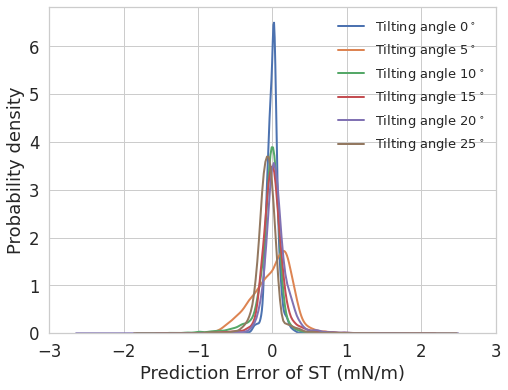

In [ ]:
sns.set_theme(style='whitegrid', font_scale=1.5)
path='/content/drive/My Drive/DropLev/for_draft/In_silico/'
date=str('20220406')
thickness=2
angles=np.array([0, 5, 10, 15, 20, 25])
savefig=False

plt.figure(figsize=(8,6))
for i in range(len(angles)):
  error_test_tilt=[]
  for j in range(6):
    file1=pd.read_csv(path+'tilt_training_outcome_test_degree_%.2f_rep_%d_' %(angles[i], j) + date)
    error_test_tilt.append(file1.Test_labels-file1.Test_pred)
    average_error=[np.mean(k) for k in zip(*error_test_tilt)]
  sns.distplot(average_error, hist=False, kde=True, kde_kws=dict(linewidth=thickness), label='Tilting angle %d$^\circ$' %angles[i])
plt.ylabel("Probability density")
plt.xlabel("Prediction Error of ST (mN/m)")
plt.xlim(-3, 3)
plt.legend(frameon=False, prop={"size":13})
if savefig==True:
  plt.savefig(path+'Error_distrib_Vs_ST_degree_of_tilt_svg_'+date, dpi=300, format='svg')
  plt.savefig(path+'Error_distrib_Vs_ST_degree_of_tilt_png_'+date, dpi=300, format='png')

In [ ]:
data = list(mae_all.items())
an_array = np.array(data)
Mae_values=an_array[:, 1][:]
Mae_avg=[]
j=0
for i in range(int(len(mae_all)/5)):
  Mae_avg.append(np.mean(Mae_values[j:j+5]))
  j=j+5

Mae_values

In [ ]:
Mae_avg=[]
max_err=[]
min_err=[]
err_diff=[]
repeat=6
j=0
for i in range(int(len(Mae_values)/repeat)):
  Mae_avg.append(np.mean(Mae_values[j:j+repeat]))
  max_err.append(max(Mae_values[j:j+repeat]))
  min_err.append(min(Mae_values[j:j+repeat]))
  err_diff.append((max(Mae_values[j:j+repeat])-min(Mae_values[j:j+repeat]))/2)
  j=j+repeat


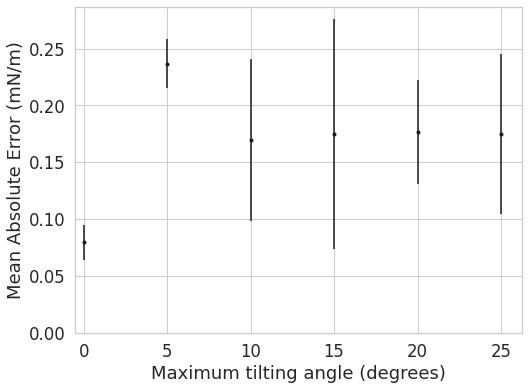

In [ ]:
from statistics import stdev
sns.set_theme(style='whitegrid', font_scale=1.5)
savefig=False

Mae_0=[0.11, 0.07, 0.08, 0.08, 0.07, 0.07]
Mae_5=[0.27, 0.23, 0.24, 0.22, 0.25, 0.21]
Mae_10=[0.11, 0.26, 0.15, 0.12, 0.12, 0.26]
Mae_15=[0.15, 0.09, 0.07, 0.21, 0.35, 0.18]
Mae_20=[0.19, 0.10, 0.20, 0.23, 0.19, 0.15]
Mae_25=[0.17, 0.12, 0.24, 0.28, 0.11, 0.13]

Mae_avg=[np.mean(Mae_0), np.mean(Mae_5), np.mean(Mae_10), np.mean(Mae_15), np.mean(Mae_20), np.mean(Mae_25)]

yerr=[stdev(Mae_0), stdev(Mae_5), stdev(Mae_10), stdev(Mae_15), stdev(Mae_20), stdev(Mae_25)]
angles=np.array([0, 5, 10, 15, 20, 25])

plt.figure(figsize=(8,6))
# plt.plot(angles, Mae_avg, 'ok')
plt.errorbar(angles, Mae_avg, yerr, fmt='.k')
# plt.vlines(angles, min_err, max_err, color='k')  # draw a vertical line
plt.xlabel('Maximum tilting angle (degrees)')
plt.ylabel('Mean Absolute Error (mN/m)')
plt.xlim(-0.5)
plt.ylim(0)
if savefig==True:
  plt.savefig(path+'MAE_Vs_ST_degree_of_tilt_svg_'+date, dpi=300, format='svg')
  plt.savefig(path+'MAE_Vs_ST_degree_of_tilt_png_'+date, dpi=300, format='png')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


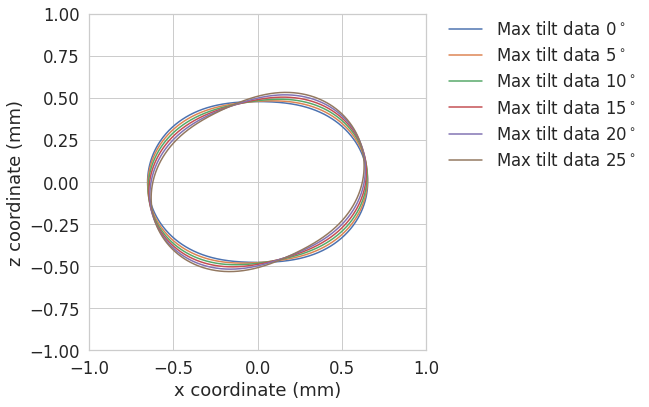

In [ ]:
dataset900=pd.read_csv('/content/drive/MyDrive/DropLev/for_draft/In_silico/dataset/raw_dataset_same_theta_after_conditions_900points.csv', ';')
sampling=900
path='/content/drive/My Drive/DropLev/for_draft/In_silico/'
date=str('20220406')

sns.set_theme(style='whitegrid', font_scale=1.5)
savefig=True
angles=[0, 5, 10, 15, 20, 25]
degree2rad=np.pi/180

plt.figure(figsize=(8,6))
# plt.title('Cartesian coordinates')
# plt.plot(range(-1,2), np.repeat(0, len(range(-1,2))), '--b')
# plt.plot(np.repeat(0, len(range(-1,2))), range(-1,2), '--b')
for i in range(len(angles)):
  angle=np.repeat(angles[i], len(dataset900))*degree2rad
  x, y=pol2cart_theta(dataset900.iloc[0, 0:sampling].values, dataset900.iloc[0, sampling:sampling*2].values)
  # Counter clockwise rotation if angle > 0 and clockwise if angle < 0
  rot_x = np.multiply(np.cos(angle)[0, np.newaxis], x) - np.multiply(np.sin(angle)[0, np.newaxis], y)
  rot_y = np.multiply(np.sin(angle)[0, np.newaxis], x) + np.multiply(np.cos(angle)[0, np.newaxis], y)
  plt.plot(rot_x, rot_y, label='Max tilt data %d$^\circ$' %angles[i])
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
plt.xlabel('x coordinate (mm)')
plt.ylabel('z coordinate (mm)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, frameon=False)
plt.tight_layout()
plt.gcf()
if savefig==True:
  plt.savefig(path+'tilted_pos_contours_svg'+date, dpi=300, format='svg')
  plt.savefig(path+'tilted_pos_contours_png'+date, dpi=300, format='png')



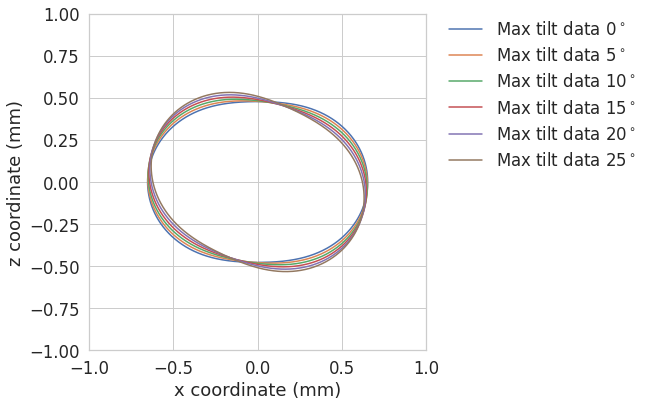

In [ ]:
savefig=True

plt.figure(figsize=(8,6))
# plt.title('Cartesian coordinates')
# plt.plot(range(-1,2), np.repeat(0, len(range(-1,2))), '--b')
# plt.plot(np.repeat(0, len(range(-1,2))), range(-1,2), '--b')
for i in range(len(angles)):
  angle=np.repeat(-angles[i], len(dataset900))*degree2rad
  x, y=pol2cart_theta(dataset900.iloc[0, 0:sampling].values, dataset900.iloc[0, sampling:sampling*2].values)
  # Counter clockwise rotation if angle > 0 and clockwise if angle < 0
  rot_x = np.multiply(np.cos(angle)[0, np.newaxis], x) - np.multiply(np.sin(angle)[0, np.newaxis], y)
  rot_y = np.multiply(np.sin(angle)[0, np.newaxis], x) + np.multiply(np.cos(angle)[0, np.newaxis], y)
  plt.plot(rot_x, rot_y, label='Max tilt data %d$^\circ$' %angles[i])
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
plt.xlabel('x coordinate (mm)')
plt.ylabel('z coordinate (mm)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, frameon=False)
plt.tight_layout()
plt.gcf()
if savefig==True:
  plt.savefig(path+'tilted_neg_contours_svg'+date, dpi=300, format='svg')
  plt.savefig(path+'tilted_neg_contours_png'+date, dpi=300, format='png')

In [ ]:

min_val, max_val = -angles[i]*degree2rad, angles[i]*degree2rad
range_size = (max_val - min_val)  
# np.random.seed(1)
angle=np.repeat(45*degree2rad, num_sample) #np.random.rand(num_sample) * range_size + min_val

x, y=pol2cart_theta(dataset900.iloc[:, 0:sampling].values, dataset900.iloc[:, sampling:sampling*2].values)
rot_x = np.multiply(np.cos(angle)[:, np.newaxis], x) - np.multiply(np.sin(angle)[:, np.newaxis], y)
rot_y = np.multiply(np.sin(angle)[:, np.newaxis], x) + np.multiply(np.cos(angle)[:, np.newaxis], y)

# rot_rho, rot_phi = cart2pol(rot_x, rot_y)

i_max=find_nearest(angle, max(angle))[1]
i_min=find_nearest(angle, min(angle))[1]

plt.figure()
plt.plot(x[i_max], y[i_max])
plt.plot(rot_x[i_max], rot_y[i_max])
plt.plot(x[i_min], y[i_min])
plt.plot(rot_x[i_min], rot_y[i_min])
plt.plot(x[i_min], y[i_min])
plt.plot(rot_x[i_min], rot_y[i_min])
plt.plot(range(-1,2), np.repeat(0, len(range(-1,2))), '--b')
plt.plot(np.repeat(0, len(range(-1,2))), range(-1,2), '--b')
ax = plt.gca()
ax.set_aspect(1)
# ax.set_xlim([-0.65,0.65])
# ax.set_ylim([-0.65,0.65])

plt.figure()
plt.plot(x[i_max]-rot_x[i_max])
plt.plot(x[i_min]-rot_x[i_min])

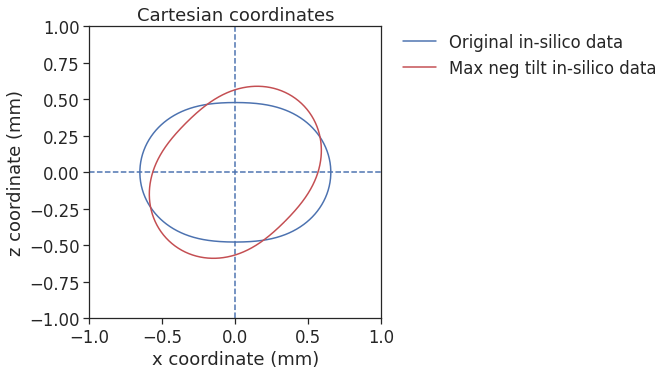

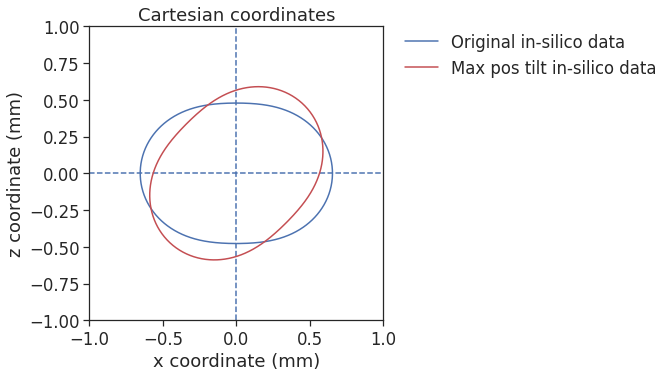

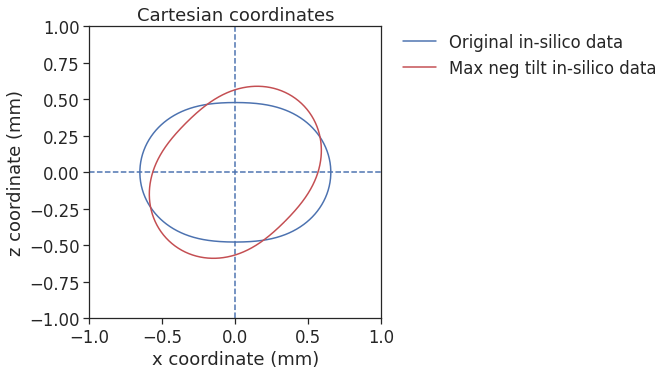

In [ ]:
i_max=find_nearest(angle, max(angle))[1]
i_min=find_nearest(angle, min(angle))[1]

plt.figure(figsize=(8,6))
plt.title('Cartesian coordinates')
plt.plot(range(-1,2), np.repeat(0, len(range(-1,2))), '--b')
plt.plot(np.repeat(0, len(range(-1,2))), range(-1,2), '--b')
plt.plot(x[i_max], y[i_max], 'b', label='Original in-silico data')
plt.plot(rot_x[i_max], rot_y[i_max], 'r', label='Max pos tilt in-silico data')
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
plt.xlabel('x coordinate (mm)')
plt.ylabel('z coordinate (mm)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, frameon=False)
plt.tight_layout()
plt.gcf()

plt.figure(figsize=(8,6))
plt.title('Cartesian coordinates')
plt.plot(range(-1,2), np.repeat(0, len(range(-1,2))), '--b')
plt.plot(np.repeat(0, len(range(-1,2))), range(-1,2), '--b')
plt.plot(x[i_min], y[i_min], 'b', label='Original in-silico data')
plt.plot(rot_x[i_min], rot_y[i_min], 'r', label='Max neg tilt in-silico data')
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
plt.xlabel('x coordinate (mm)')
plt.ylabel('z coordinate (mm)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, frameon=False)
plt.tight_layout()
plt.gcf()

### Contour distortion

In [ ]:
#Import data

dataset=pd.read_csv('/content/drive/MyDrive/DropLev/for_draft/In_silico/dataset/raw_dataset_same_theta_after_conditions_900points.csv', ';')
dataset.tail()

In [ ]:

#Choosing 175 points with constant phi

sampling=900
points=175
new_phi=np.linspace(-3.13, 3.13, points)

new_rho=[]

### Interpolate to find all the radius for specific theta
for k in range(len(dataset)):
  x, y = pol2cart_theta(dataset.iloc[k, 0:sampling].values, dataset.iloc[k, sampling:2*sampling].values)
  rho, phi=cart2pol(x, y)
  contour_interp=interp1d(phi, rho, kind='slinear')
  new_rho.append(contour_interp(new_phi))

theta = []
theta_array = []
features = pd.DataFrame()

rho_n=[]

for k in range(points):
  rho_n.append(str('row_%d' %k))

features[rho_n]=new_rho

# for k in range(points):
#   theta.append(str('theta_%d' %k))

# x, y = pol2cart(new_rho, new_phi)
# theta_array = azimuth(x, y)

# features[theta] = theta_array

features_DF=pd.concat([features, dataset.iloc[:, 2*sampling:]], axis=1)

AR=features_DF.pop('AR')
radius=features_DF.pop('radius')
vol=features_DF.pop('vol')
features_DF.tail()


dataset=features_DF.copy()

dataset.tail()





/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


,row_0,row_1,row_2,row_3,row_4,row_5,row_6,row_7,row_8,row_9,...,row_167,row_168,row_169,row_170,row_171,row_172,row_173,row_174,Ps,ST
50423,0.720853,0.720616,0.720093,0.719286,0.718199,0.716837,0.715208,0.713321,0.711185,0.708811,...,0.713322,0.715209,0.716837,0.718198,0.719285,0.720093,0.720617,0.720854,2440.778163,46.934689
50424,0.686396,0.686239,0.685892,0.685357,0.684636,0.683733,0.682653,0.681401,0.679984,0.678410,...,0.681402,0.682653,0.683733,0.684636,0.685357,0.685892,0.686240,0.686397,2409.976323,63.571301
50425,0.787369,0.787164,0.786711,0.786013,0.785072,0.783894,0.782484,0.780851,0.779002,0.776948,...,0.780851,0.782484,0.783893,0.785071,0.786012,0.786711,0.787165,0.787370,2246.471091,59.265300
50426,0.588555,0.588348,0.587890,0.587183,0.586232,0.585039,0.583613,0.581961,0.580090,0.578012,...,0.581961,0.583614,0.585039,0.586231,0.587183,0.587890,0.588348,0.588556,3058.148777,50.762339
50427,0.692031,0.691883,0.691555,0.691050,0.690369,0.689515,0.688495,0.687312,0.685974,0.684487,...,0.687313,0.688495,0.689515,0.690368,0.691049,0.691555,0.691883,0.692032,1656.011831,32.620363


In [ ]:
import random 
points=175
pxl1=0.83/217.5 #mm
phi=np.linspace(-3.13, 3.13, points)
# percent=0.5 #50%

random_noise=pxl1*np.random.uniform(-1, 1, size=[len(dataset), 175])
scale_list=np.array([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]) #
noisy_rho={}

for i in range(len(scale_list)):
  noisy_rho[i]=dataset.iloc[:, 0:175]+random_noise*scale_list[i]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in double_scalars


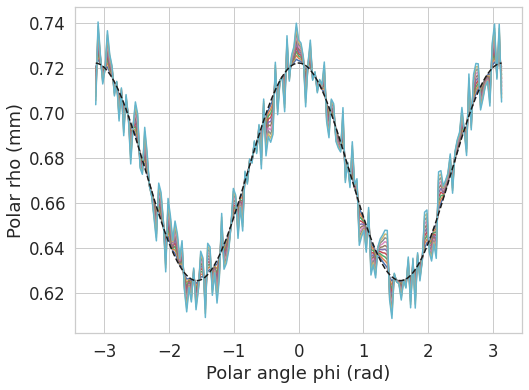

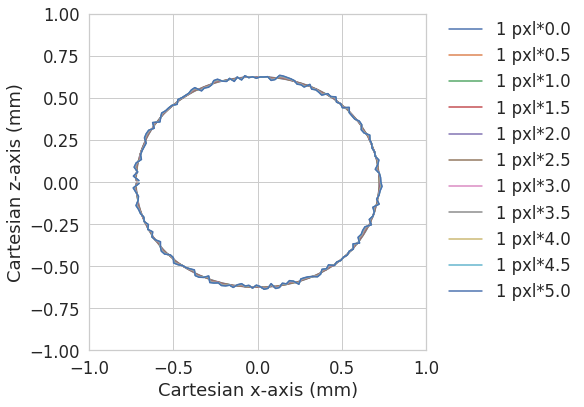

Droplet's characteristics: 1.37 μL, 2765.23 Pa, 70.89 mN/m


In [ ]:
sns.set_theme(style='whitegrid', font_scale=1.5)

path='/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/data_distribution/'
savefig=False

x,y=pol2cart(dataset.iloc[1, 0:points].values, phi)
volume=calc_volume(x,y)
R_sph=calc_R_sph(volume)

plt.figure(figsize=(8,6))
for i in range(len(scale_list)-1):
  plt.plot(phi, noisy_rho[i+1].iloc[1, :], label='1xpl*%.1f' %scale_list[i+1])
plt.plot(phi, dataset.iloc[1, 0:points], 'k--', label='No noise')

plt.xlabel('Polar angle phi (rad)')
plt.ylabel('Polar rho (mm)')
if savefig==True:
  plt.savefig(str(path+'noisy_contours_polar_ %.2f_μL_%.2f_Pa_%.2f_mNm_svg' %(-volume, dataset.iloc[1, 175], dataset.iloc[1, 176])), dpi=300, format='svg')
  plt.savefig(str(path+'noisy_contours_polar_ %.2f_μL_%.2f_Pa_%.2f_mNm_png' %(-volume, dataset.iloc[1, 175], dataset.iloc[1, 176])), dpi=300, format='png')
# ax1.legend(frameon=False)

plt.figure(figsize=(8,6))
for i in range(len(scale_list)):
  x, y = pol2cart(noisy_rho[i].iloc[1, :].values, phi)
  plt.plot(x, y, label='1 pxl*%.1f' %scale_list[i])
# x, y = pol2cart(dataset.iloc[1, 0:points].values, phi)
# plt.plot(x, y, 'k--', label='No noise')
plt.xlabel('Cartesian x-axis (mm)')
plt.ylabel('Cartesian z-axis (mm)')
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, frameon=False)
plt.tight_layout()
plt.gcf()


if savefig==True:
  plt.savefig(str(path+'noisy_contours_Cart_ %.2f μL_%.2f Pa_%.2f mNm_svg' %(-volume, dataset.iloc[1, 175], dataset.iloc[1, 176])), dpi=300, format='svg')
  plt.savefig(str(path+'noisy_contours_Cart_ %.2f μL_%.2f Pa_%.2f mNm_png' %(-volume, dataset.iloc[1, 175], dataset.iloc[1, 176])), dpi=300, format='png')
plt.show()

print('''Droplet's characteristics: %.2f μL, %.2f Pa, %.2f mN/m''' %(-volume, dataset.iloc[1, 175], dataset.iloc[1, 176]))

In [ ]:
# #Remove features that are not used in the training

# vol=dataset.pop('vol')
# AR=dataset.pop('AR')
# radius=dataset.pop('radius')


In [ ]:
from numpy.random import seed

sseed=50
def build_model():
  seed(sseed)
  tf.random.set_seed(sseed)
  model = keras.Sequential([
    layers.Dense(50, activation=tf.nn.swish, input_shape=[len(normed_train_data[0].keys())]), #kernel_regularizer='l2', 
    layers.Dense(40, activation=tf.nn.softplus),
    layers.Dense(30, activation=tf.nn.swish),
    layers.Dense(20, activation=tf.nn.softplus),
    layers.Dense(15, activation=tf.nn.swish),
    layers.Dense(10, activation=tf.nn.softplus),
    layers.Dense(5, activation=tf.nn.swish),
    layers.Dense(1)
  ])

  #optimizer = tf.keras.optimizers.RMSprop(0.0000001)
  #optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.0001)
  optimizer = tf.keras.optimizers.Adam() #learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False
  #optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.8, beta_2=0.995)

  #model.compile(loss='mean_squared_error',
  #              optimizer=optimizer,
  #              metrics=['mean_absolute_error', 'mean_squared_error'])
  
  model.compile(loss='mean_absolute_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  
  
  return model


class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

def plot_history(hist, savefig=False, path='/content/drive/My Drive/DropLev/Dataset/In_Silico/'):
  sns.set_theme(style='ticks', font_scale=1.5)

  plt.figure(figsize=(8,6))
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Abs Error of ST (mN/m)')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,0.4])
  plt.legend()
  if savefig==True:
    plt.savefig(path+'training_outcome_MAE_svg', dpi=300, format='svg')
    plt.savefig(path+'training_outcome_MAE_png', dpi=300, format='png')

  plt.figure(figsize=(8,6))
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Square Error of ST (mN$^2$/m$^2$)')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  # plt.ylim([0,0.05])
  plt.legend()
  if savefig==True:
    plt.savefig(path+'training_outcome_MSE_svg', dpi=300, format='svg')
    plt.savefig(path+'training_outcome_MSE_png', dpi=300, format='png')
  plt.show()



In [ ]:
#Min-Max transformation

def MinMaxTransformTrain(train_dataset, points):

  max_rho=[]
  min_rho=[]
  # min_theta=[]
  # max_theta=[]
  for i in range(len(train_dataset)):
    max_rho.append(max(train_dataset.iloc[i, 0:points].values))
    min_rho.append(min(train_dataset.iloc[i, 0:points].values))
    # max_theta.append(max(train_dataset.iloc[i, points:2*points].values))
    # min_theta.append(min(train_dataset.iloc[i, points:2*points].values))

  # print(min(min_rho), max(max_rho), min(min_theta), max(max_theta))

  # Change the range of rho from 0 to 1

  OldMax= max(max_rho)
  OldMin=min(min_rho)

  NewValues_rho={}

  OldRange = (OldMax - OldMin)
  for i in range(len(train_dataset)):
    if (OldRange == 0):
        NewValue = OldMin
        NewValues_rho[i]=NewValue
    else:
        NewValue = (train_dataset.iloc[i, 0:points] - OldMin)/(OldMax-OldMin) 
        NewValues_rho[i]=NewValue

  # Change the range of theta from 0 to 1

  # OldMax= max(max_theta)
  # OldMin=min(min_theta)

  # NewValues_theta={}

  # OldRange = (OldMax - OldMin)
  # for i in range(len(train_dataset)):
  #   if (OldRange == 0):
  #       NewValue = OldMin
  #       NewValues_theta[i]=NewValue
  #   else:
  #       NewValue = (train_dataset.iloc[i, points:2*points] - OldMin)/(OldMax-OldMin) 
  #       NewValues_theta[i]=NewValue

  df_rho=pd.DataFrame.from_dict(NewValues_rho).T
  # df_theta=pd.DataFrame.from_dict(NewValues_theta).T

  # new_df=pd.concat([df_rho, df_theta], axis=1)

  return df_rho


def MinMaxTransformTest(test_dataset, train_dataset, points):

  max_rho=[]
  min_rho=[]
  # min_theta=[]
  # max_theta=[]
  for i in range(len(train_dataset)):
    max_rho.append(max(train_dataset.iloc[i, 0:points].values))
    min_rho.append(min(train_dataset.iloc[i, 0:points].values))
    # max_theta.append(max(train_dataset.iloc[i, points:2*points].values))
    # min_theta.append(min(train_dataset.iloc[i, points:2*points].values))

  # print(min(min_rho), max(max_rho), min(min_theta), max(max_theta))

  # Change the range of rho from 0 to 1

  OldMax= max(max_rho)
  OldMin=min(min_rho)

  NewValues_rho={}

  OldRange = (OldMax - OldMin)
  for i in range(len(test_dataset)):
    if (OldRange == 0):
        NewValue = OldMin
        NewValues_rho[i]=NewValue
    else:
        NewValue = (test_dataset.iloc[i, 0:points] - OldMin)/(OldMax-OldMin) 
        NewValues_rho[i]=NewValue

  # Change the range of theta from 0 to 1

  # OldMax= max(max_theta)
  # OldMin=min(min_theta)

  # NewValues_theta={}

  # OldRange = (OldMax - OldMin)
  # for i in range(len(test_dataset)):
  #   if (OldRange == 0):
  #       NewValue = OldMin
  #       NewValues_theta[i]=NewValue
  #   else:
  #       NewValue = (test_dataset.iloc[i, points:2*points] - OldMin)/(OldMax-OldMin) 
  #       NewValues_theta[i]=NewValue

  df_rho=pd.DataFrame.from_dict(NewValues_rho).T
  # df_theta=pd.DataFrame.from_dict(NewValues_theta).T

  # new_df=pd.concat([df_rho, df_theta], axis=1)

  return df_rho


def min_max_norm(x):
  return (x-stats['min'])/(stats['max']-stats['min'])


In [ ]:
## Re-scale target feature
def rescaling(target):
  min=stats.loc['ST']['min']
  max=stats.loc['ST']['max']
  target=np.asarray(target)
  return (max-min)*(target)+min


In [ ]:
#Normalizing data
points=175

#Normed data with noise
# Normed_rho_with_noise={}
Normed_data={}

for i in range(len(scale_list)):
  Normed_data[i] = MinMaxTransformTrain(noisy_rho[i], points)
  # Normed_data_with_noise[i]=pd.concat([Normed_rho_with_noise, normed_data.iloc[:, 175:]], axis=1)


In [ ]:
#Inspect the data
stats = dataset.iloc[:, points:].describe()
stats = stats.transpose()


#Normalizing the rest of the data
normed_data_rest = min_max_norm(dataset.iloc[:, points:])
# normed_data['volume'] = normed_data_rest.vol


for i in range(len(scale_list)):
  # Normed_data_with_noise[i]['volume'] = normed_data_rest.vol
  Normed_data[i]['Ps'] = normed_data_rest.Ps
  Normed_data[i]['ST'] = normed_data_rest.ST


In [ ]:
from sklearn.utils import shuffle

normed_data={}

np.random.seed(1234)

for i in range(len(scale_list)):
  normed_data[i]=shuffle(Normed_data[i], random_state=0)
  normed_data[i].reset_index(drop=True, inplace=True)


In [ ]:
#Noisy data
#Split data into train and test
normed_train_data={}
normed_test_data={}
train_labels={}
test_labels={}


mae_all={}
rows_05_all={}
rows_1_all={}
rows_2_all={}



path='/content/drive/My Drive/DropLev/for_draft/In_silico/'
date=str('20220406')

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0, restore_best_weights=True)


for i in range(len(scale_list)):
  np.random.seed(1234)
  normed_train_data[i] = normed_data[i].sample(frac=0.8,random_state=0)
  normed_test_data[i] = normed_data[i].drop(normed_train_data[i].index)
  train_labels[i] = normed_train_data[i].pop('ST')
  train_labels[i].reset_index(drop=True, inplace=True)
  test_labels[i] = normed_test_data[i].pop('ST')
  test_labels[i].reset_index(drop=True, inplace=True)


  for j in range(6):
    
    sseed=j

    model = build_model()

    EPOCHS = 1000

    # The patience parameter is the amount of epochs to check for improvement
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0, restore_best_weights=True)

    history = model.fit(normed_train_data[i], train_labels[i], epochs=EPOCHS,
                        validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    ## Re-scale target feature
    test_predictions = model.predict(normed_test_data[i]).flatten()
    train_predictions = model.predict(normed_train_data[i]).flatten()

    ST_real_test=rescaling(test_labels[i])
    ST_pred_test=rescaling(test_predictions)

    ST_real_train=rescaling(train_labels[i])
    ST_pred_train=rescaling(train_predictions)  

    error_test = ST_pred_test - ST_real_test
    error_test_test=np.asarray(error_test)

    rows_05=(error_test_test[(error_test_test >= -0.5) & (error_test_test <= 0.5)])
    rows_1=(error_test_test[(error_test_test >= -1) & (error_test_test <= 1)])
    rows_2=(error_test_test[(error_test_test >= -2) & (error_test_test <= 2)])

    rows_05_all[i,j]=len(rows_05)/len(error_test)

    rows_1_all[i,j]=len(rows_1)/len(error_test)

    rows_2_all[i,j]=len(rows_2)/len(error_test)

    mae_all[i,j]=(sum(abs(error_test_test))/len(error_test_test))

    hist.to_csv(path+'history_degree_noise_%.2f_rep_%d_MAE_%.2f_' %(scale_list[i], j, mae_all[i, j]) +date)

    noisy_training_outcome_test=pd.DataFrame(data=np.array([ST_real_test, ST_pred_test]).T, columns=[ 'Test_labels', 'Test_pred'])
    noisy_training_outcome_test.to_csv(path+'noisy_training_outcome_test_degree_%.2f_rep_%d_' %(scale_list[i], j) + date, index=False)  #Saves the file
    noisy_training_outcome_train=pd.DataFrame(data=np.array([ST_real_train, ST_pred_train]).T, columns=[ 'Train_labels', 'Train_pred'])
    noisy_training_outcome_train.to_csv(path+'noisy_training_outcome_train_degree_%.2f_rep_%d_' %(scale_list[i], j) + date, index=False)  #Saves the file



/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



........................................

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



...............................................
...........................................................
...........................................................................
....................................................
............................
..................................................................
......................................................................................
..........................................................
...............................................................
......................................................
.......................................................................................
......................................
...........................................................
.......................................
....................................................................
........................................................................................
................

#### Figures

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

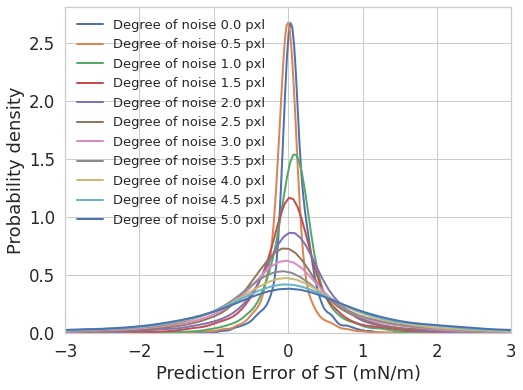

In [ ]:
sns.set_theme(style='whitegrid', font_scale=1.5)
path='/content/drive/My Drive/DropLev/for_draft/In_silico/'
date=str('20220406')
thickness=2
scale_list=np.array([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]) 
savefig=True

plt.figure(figsize=(8,6))
for i in range(len(scale_list)):
  error_test_noise=[]
  for j in range(6):
    file=pd.read_csv(path+'noisy_training_outcome_test_degree_%.2f_rep_%d_' %(scale_list[i], j) + date)
    error_test_noise.append(file.Test_pred-file.Test_labels)
    average_error=[np.mean(k) for k in zip(*error_test_noise)]
  sns.distplot(average_error, hist=False, kde=True, kde_kws=dict(linewidth=thickness), label='Degree of noise %.1f pxl' %scale_list[i])
plt.ylabel("Probability density")
plt.xlabel("Prediction Error of ST (mN/m)")
plt.xlim(-3, 3)
plt.legend(frameon=False, prop={"size":13})
if savefig==True:
  plt.savefig(path+'Error_distrib_Vs_ST_degree_of_noise_svg_'+date, dpi=300, format='svg')
  plt.savefig(path+'Error_distrib_Vs_ST_degree_of_noise_png_'+date, dpi=300, format='png')

In [ ]:

# # all_mae=np.insert(np.asarray([list(mae_noisy.items())])[0][:, 1], 0, mae)
# all_degrees=np.insert(scale_list, 0, 0)

# # date='20220406'
# savefig=True
# path='/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/training_outcome/'

# plt.figure(figsize=(8,6))
# plt.plot(all_degrees, mae_all, '-o')
# plt.xlabel('Degree of noise (pixels)')
# plt.ylabel('Mean absolute error (mN/m)')
# if savefig==True:
#   plt.savefig(path+'MAE_Vs_degree_of_noise_svg_'+date, dpi=300, format='svg')
#   plt.savefig(path+'MAE_Vs_degree_of_noise_png_'+date, dpi=300, format='png')

# print(all_mae)


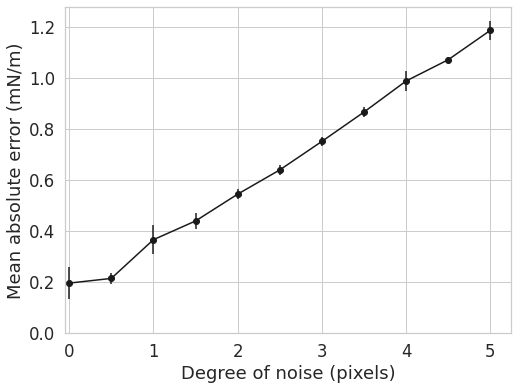

In [ ]:
from statistics import stdev

mae_0=[0.08, 0.24, 0.24, 0.21, 0.18, 0.23]
mae_05=[0.23, 0.20, 0.24, 0.20, 0.23, 0.19]
mae_1=[0.41, 0.32, 0.46, 0.36, 0.34, 0.31]
mae_15=[0.45, 0.49, 0.43, 0.40, 0.43, 0.44]
mae_2=[0.53, 0.53, 0.57, 0.54, 0.57, 0.53]
mae_25=[0.65, 0.63, 0.67, 0.63, 0.62, 0.64]

mae_3=[0.78, 0.74, 0.75, 0.73, 0.76, 0.75]
mae_35=[0.86, 0.88, 0.88, 0.85, 0.84, 0.89]
mae_4=[0.97, 1.00, 0.97, 1.06, 0.95, 0.98]
mae_45=[1.08, 1.08, 1.08, 1.06, 1.07, 1.06]
mae_5=[1.18, 1.16, 1.26, 1.17, 1.18, 1.17]

all_mae=np.array([np.mean(mae_0), np.mean(mae_05), np.mean(mae_1), np.mean(mae_15), np.mean(mae_2), np.mean(mae_25), np.mean(mae_3), np.mean(mae_35), np.mean(mae_4), np.mean(mae_45), np.mean(mae_5)])
scale_list=np.array([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]) 

 
yerr=np.array([stdev(mae_0), stdev(mae_05), stdev(mae_1), stdev(mae_15), stdev(mae_2), stdev(mae_25), stdev(mae_3), stdev(mae_35), stdev(mae_4), stdev(mae_45), stdev(mae_5)])

savefig=True
path='/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/training_outcome/'

plt.figure(figsize=(8,6))
plt.plot(scale_list, all_mae, '-ok')
plt.errorbar(scale_list, all_mae, yerr, fmt='.k')
plt.xlabel('Degree of noise (pixels)')
plt.ylabel('Mean absolute error (mN/m)')
plt.xlim(-0.05)
plt.ylim(0)
if savefig==True:
  plt.savefig(path+'MAE_Vs_degree_of_noise_with_errorbars_svg_'+date, dpi=300, format='svg')
  plt.savefig(path+'MAE_Vs_degree_of_noise_with_errorbars_png_'+date, dpi=300, format='png')


In [ ]:
files=glob.glob(path+"/*")

for i in range(len(files)):
  if files[i].endswith('.csv'):
    
    for j in range(len(scale_list)):
      print(files[j])

In [ ]:
import glob

#Error distribution
thickness=3

path='/content/drive/My Drive/DropLev/for_draft/In_silico/'

files=glob.glob(path+"/*")

for i in range(len(files)):
  if files[i].endswith('.csv'):
    j=files[i]
    for j in range(len(scale_list)):
      if j.startswith('noisy_training_outcome_degree_%.2f' %scale_list[j]):
        dw

plt.figure(figsize=(8,6))
sns.distplot(error_test_test, hist=False, kde=True, kde_kws=dict(linewidth=thickness), label='Degree of noise 0')
for i in range(len(scale_list)):
  sns.distplot(error_test_noisy[i], hist=False, kde=True, kde_kws=dict(linewidth=thickness), label='Degree of noise %.2f' %scale_list[i])
plt.ylabel("Probability density")
plt.xlabel("Prediction Error of ST (mN/m)")
plt.legend(frameon=False, prop={"size":13})
if savefig==True:
  plt.savefig(path+'Error_distrib_Vs_ST_degree_of_noise_svg_'+date, dpi=300, format='svg')
  plt.savefig(path+'Error_distrib_Vs_ST_degree_of_noise_png_'+date, dpi=300, format='png')

In [ ]:
# path='/content/drive/My Drive/DropLev/for_draft/In_silico/'
# date='20211209'
# mae=0.34
# mae_noisy=np.array([0.52, 0.54, 0.66, 0.65, 0.70, 0.81, 0.93, 0.96, 1.07, 1.22])

# hist_noisy={}

# scale_list=np.array([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
# for i in range(len(scale_list)):
#   hist_noisy[i]=pd.read_csv(path+'history_degree_noise_%.2f_MAE_%.2f_' %(scale_list[i], mae_noisy[i]) +date)


# hist=pd.read_csv(path+'history_no_noise_MAE_%.2f_' %mae +date)


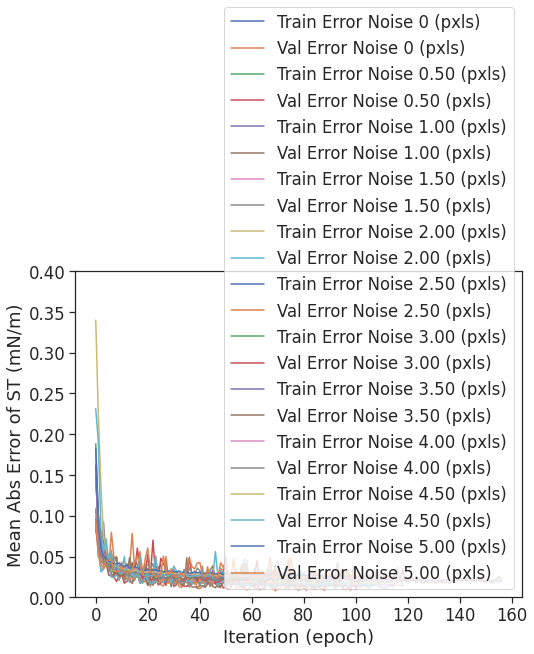

In [ ]:
#Training outcome MAE Vs epochs

sns.set_theme(style='ticks', font_scale=1.5) 
savefig=True
plt.figure(figsize=(8,6))
plt.xlabel('Iteration (epoch)')
plt.ylabel('Mean Abs Error of ST (mN/m)')
plt.ylim([0,0.4])
plt.plot(hist['epoch'], hist['mean_absolute_error'], 
          label='Train Error Noise 0 (pxls)')
plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
          label = 'Val Error Noise 0 (pxls)')
for i in range(len(scale_list)):
  plt.plot(hist_noisy[i]['epoch'], hist_noisy[i]['mean_absolute_error'], 
           label='Train Error Noise %.2f (pxls)' %scale_list[i])
  plt.plot(hist_noisy[i]['epoch'], hist_noisy[i]['val_mean_absolute_error'],
           label = 'Val Error Noise %.2f (pxls)' %scale_list[i])
plt.legend(fontsize = 5)
if savefig==True:
  path='/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/training_outcome/'
  plt.savefig(path+'MAE_Vs_epoch_noise_png_'+date, dpi=300, format='png')
  plt.savefig(path+'MAE_Vs_epoch_noise_svg_'+date, dpi=300, format='svg')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

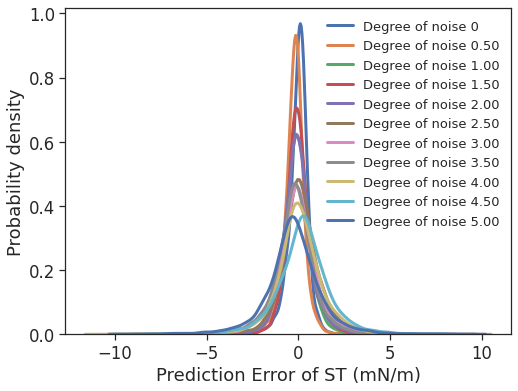

In [ ]:
#Error distribution
thickness=3

plt.figure(figsize=(8,6))
sns.distplot(error_test_test, hist=False, kde=True, kde_kws=dict(linewidth=thickness), label='Degree of noise 0')
for i in range(len(scale_list)):
  sns.distplot(error_test_noisy[i], hist=False, kde=True, kde_kws=dict(linewidth=thickness), label='Degree of noise %.2f' %scale_list[i])
plt.ylabel("Probability density")
plt.xlabel("Prediction Error of ST (mN/m)")
plt.legend(frameon=False, prop={"size":13})
if savefig==True:
  plt.savefig(path+'Error_distrib_Vs_ST_degree_of_noise_svg_'+date, dpi=300, format='svg')
  plt.savefig(path+'Error_distrib_Vs_ST_degree_of_noise_png_'+date, dpi=300, format='png')

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


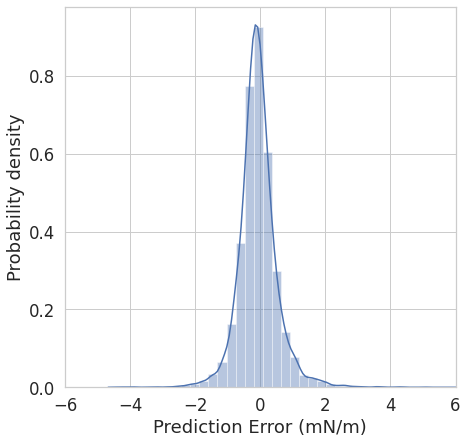

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


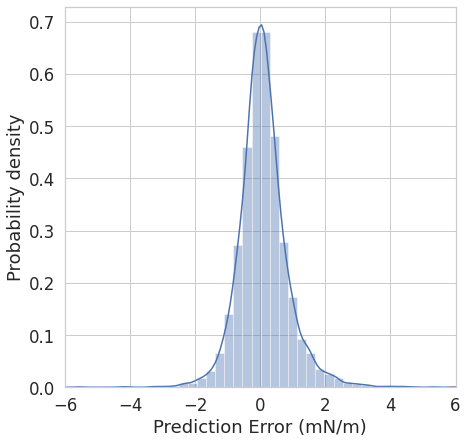

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


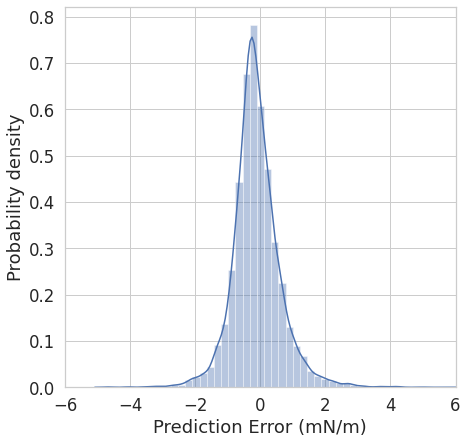

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


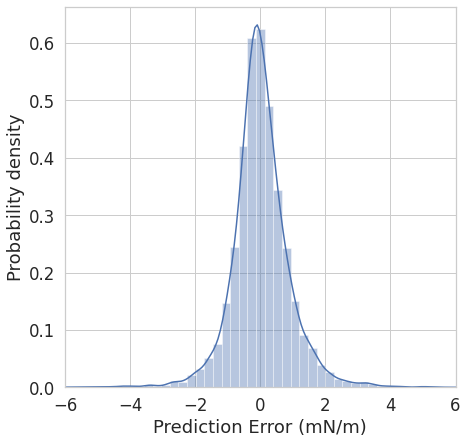

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


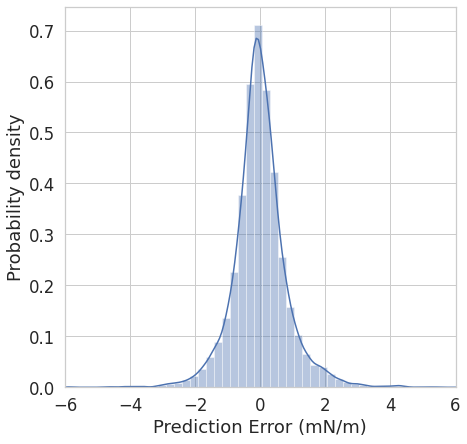

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


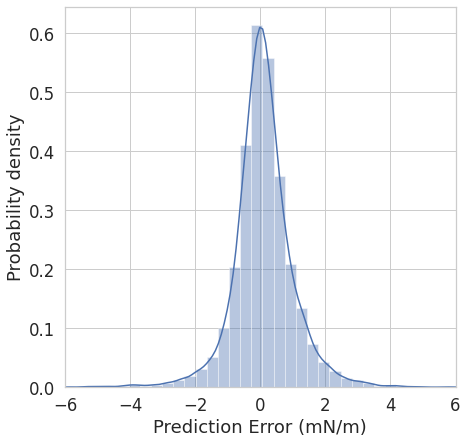

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


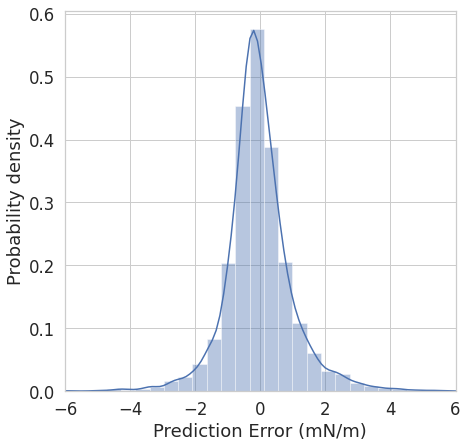

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


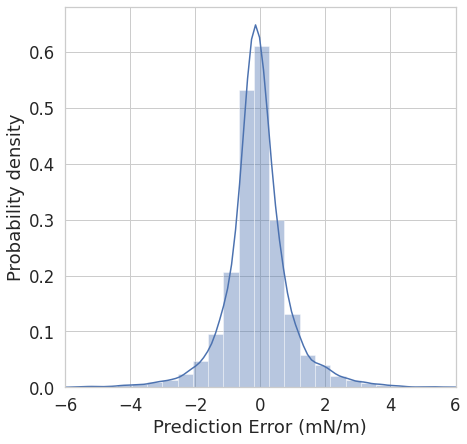

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


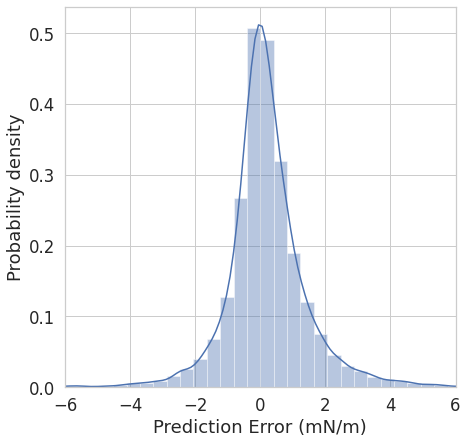

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


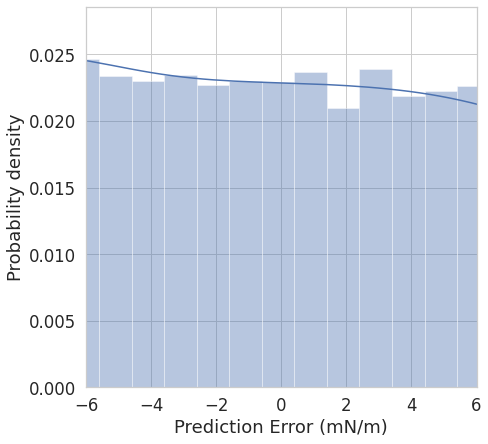

In [ ]:
# noise_test_predictions={}
# noise_train_predictions={}
# noise_error_test={}
# noise_error_train={}

# sns.set_theme(style='whitegrid', font_scale=1.5)

# for i in range(len(scale_list)):
#   noise_test_predictions[i] = model_noisy[i].predict(normed_noisy_test_data[i]).flatten()
#   noise_train_predictions[i] = model_noisy[i].predict(normed_noisy_train_data[i]).flatten()
#   noise_error_test[i] = noise_test_predictions[i] - test_labels_noise[i]
#   noise_error_train[i] = noise_train_predictions[i] - train_labels_noise[i]

#   plt.figure(figsize=(7,7))
#   sns.histplot(noise_error_test[i], bins = 50, kde=True, stat="density")
#   plt.xlabel("Prediction Error (mN/m)")
#   _ = plt.ylabel("Probability density")
#   plt.xlim(-6, 6)
#   plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/error_distr_with_noise_%.1f' %scale_list[i], dpi=300, format='svg')
#   plt.show()


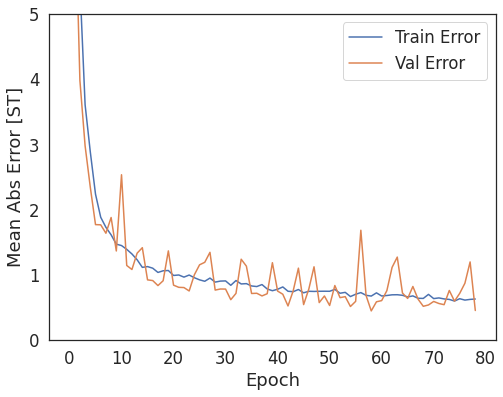

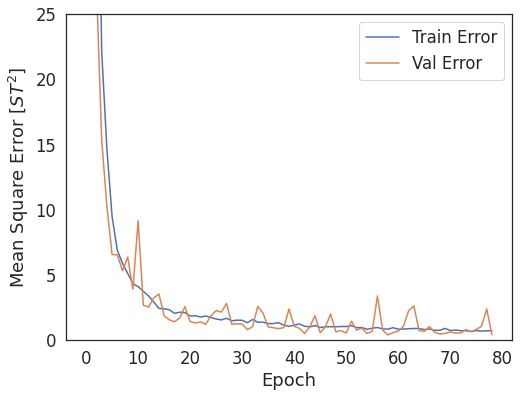

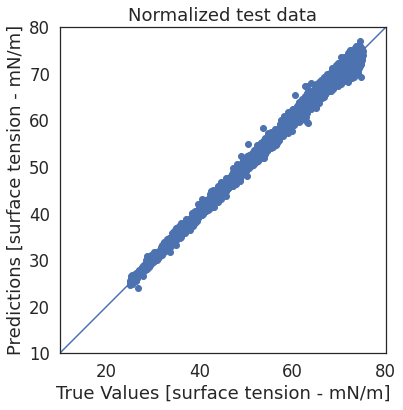

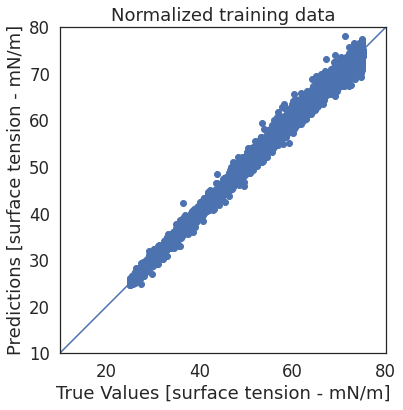

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


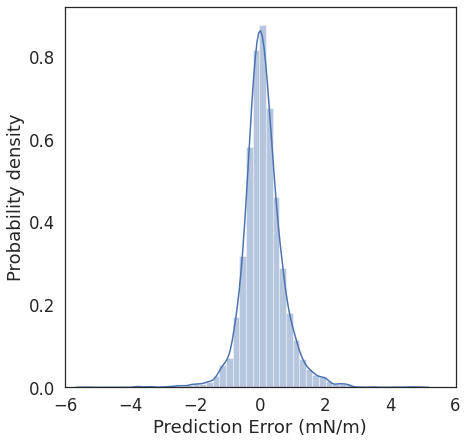

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


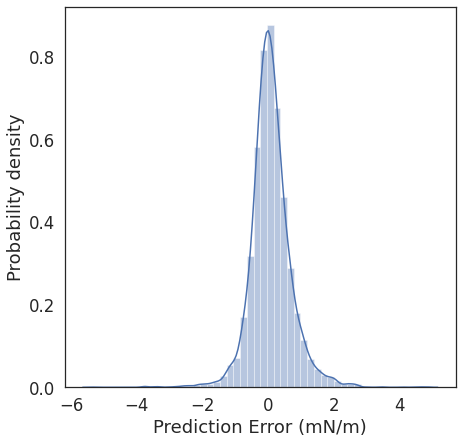

Text(0.5, 0, 'Surface tension (mN/m)')

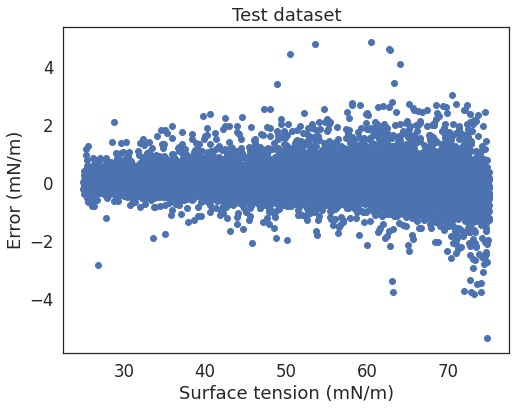

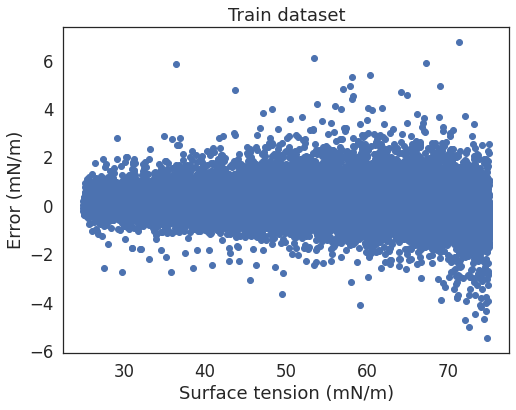

In [ ]:
# # Data without noise
# # Histrory
# plot_history(history)

# # Make predictions
# test_predictions = model.predict(normed_test_data).flatten()

# plt.figure(figsize=(8,6))
# plt.scatter(test_labels, test_predictions)
# plt.title('Normalized test data')
# plt.xlabel('True Values [surface tension - mN/m]')
# plt.ylabel('Predictions [surface tension - mN/m]')
# plt.axis('equal')
# plt.axis('square')
# plt.xlim([10,80])
# plt.ylim([10,80])
# _ = plt.plot([-100, 100], [-100, 100])
# # plt.savefig('Test_data_training', dpi=300, format='pdf')
# plt.show()

# train_predictions = model.predict(normed_train_data).flatten()

# plt.figure(figsize=(8,6))
# plt.scatter(train_labels, train_predictions)
# plt.title('Normalized training data')
# plt.xlabel('True Values [surface tension - mN/m]')
# plt.ylabel('Predictions [surface tension - mN/m]')
# plt.axis('equal')
# plt.axis('square')
# plt.xlim([10,80])
# plt.ylim([10,80])
# _ = plt.plot([-100, 100], [-100, 100])
# plt.show()


# #Error distribution

# error_test = test_predictions - test_labels

# plt.figure(figsize=(7,7))
# sns.histplot(error_test, bins = 50, kde=True, stat="density")
# plt.xlabel("Prediction Error (mN/m)")
# _ = plt.ylabel("Probability density")
# plt.xlim(-6, 6)
# # plt.savefig('error', dpi=300, format='pdf')
# plt.show()

# plt.figure(figsize=(7,7))
# sns.histplot(error_test, bins = 50, kde=True, stat="density")
# plt.xlabel("Prediction Error (mN/m)")
# _ = plt.ylabel("Probability density")
# plt.show()
# error_test = test_predictions - test_labels
# error_train = train_predictions - train_labels

# plt.figure(figsize=(8,6))
# plt.title('Test dataset')
# plt.plot(test_labels, error_test, 'o')
# plt.ylabel('Error (mN/m)')
# plt.xlabel('Surface tension (mN/m)')

# plt.figure(figsize=(8,6))
# plt.title('Train dataset')
# plt.plot(train_labels, error_train, 'o')
# plt.ylabel('Error (mN/m)')
# plt.xlabel('Surface tension (mN/m)')


In [ ]:
# #Save prediction outcome in a csv file
# error_test = test_predictions - test_labels
# error_train = train_predictions - train_labels
# outcome_train=pd.DataFrame(data=np.array([train_labels.values, train_predictions]).T, columns=['Train_labels', 'Train_pred'])
# outcome_test=pd.DataFrame(data=np.array([test_labels.values, test_predictions]).T, columns=[ 'Test_labels', 'Test_pred'])

# date=str('20211019')

# model_No=3

# data_No=46685
# ST_min=25
# ST_max=75
# vol_min=0.5
# vol_max=2.5
# Ps_min=2000
# Ps_max=4000


# filename=str('data_%d_ST_%.2f_%.2f_vol_%.2f_%.2f_Ps_%d_%d_model_%d_%s.csv' %(data_No, ST_min, ST_max, vol_min, vol_max, Ps_min, Ps_max, model_No, date))
# !mkdir -p '/content/drive/My Drive/DropLev/Outcomes/' #Ceates a folder named "MachineLearningModels"
# outcome_train.to_csv('/content/drive/My Drive/DropLev/Outcomes/'+'train_out_'+filename, index=False)  #Saves the file
# outcome_test.to_csv('/content/drive/My Drive/DropLev/Outcomes/'+'test_out_'+filename, index=False)  #Saves the file

# hist.to_csv('/content/drive/My Drive/DropLev/Outcomes/'+'history_'+filename)


## Testing new data

In [ ]:
def prep_input(input, sampling=300):
  AR=[]
  width=[]
  # plt.figure()
  for j in range(len(input)):
    x,y=pol2cart_theta(np.asarray(input.iloc[j, 0:sampling]), np.asarray(input.iloc[j, sampling:2*sampling]))
    AR.append(abs(max(y)-min(y))/abs(max(x)-min(x)))
    width.append(max(x)-min(x))

  AR=np.asarray(AR)
  width=np.asarray(width)
  input['AR']=AR

  wavelength_lim = 343 / 40 # [mm] 
  radius=width/2

  input['radius']=radius


  pre_rslt_dataset= input[input['radius'] < wavelength_lim*0.1]
  pre_rslt_dataset.reset_index(drop=True, inplace=True)

  # Capillary length check
  ST_c=np.linspace(25, 74, len(pre_rslt_dataset))
  lambda_c=np.sqrt(ST_c/9.81)
  volume_c=(4/3)*np.pi*(lambda_c/2)**3

  rslt_dataset= pre_rslt_dataset[pre_rslt_dataset['vol'] <= volume_c*0.7]
  rslt_dataset.reset_index(drop=True, inplace=True)

  #Aspect ratio
  Ar_limit=0.66

  final_dataset= rslt_dataset[rslt_dataset['AR'] > Ar_limit]
  final_dataset.reset_index(drop=True, inplace=True)

  dataset=final_dataset.copy()

  dataset.pop("AR")
  dataset.pop('radius')
  dataset.pop('vol')

  # n=250
  # for i in range(0, n, 2):
  #   dataset.pop('theta_%d' %i)

  # for i in range(0,n, 2):
  #   dataset.pop('rho_%d' %i)

  rand_cont=np.linspace(0, len(dataset)-1, 10).astype(int)

  plt.figure(figsize=(8,6))
  plt.title('Cartesian coordinates')
  for i in rand_cont:
    x, y=pol2cart_theta(dataset.iloc[i, 0:sampling].values, dataset.iloc[i, sampling:2*sampling].values)
    plt.plot(x, y, '-o')
  ax = plt.gca()
  ax.set_aspect(1)
  ax.set_xlim([-1.5,1.5])
  ax.set_ylim([-1.5,1.5])
  plt.xlabel('x coordinate (mm)')
  plt.ylabel('z coordinate (mm)')

  return dataset





In [ ]:
#Min-Max transformation

def MinMaxTransformTest(test_dataset, train_dataset, points):

  max_rho=[]
  min_rho=[]
  # min_theta=[]
  # max_theta=[]
  for i in range(len(train_dataset)):
    max_rho.append(max(train_dataset.iloc[i, points:2*points].values))
    min_rho.append(min(train_dataset.iloc[i, points:2*points].values))
    # max_theta.append(max(train_dataset.iloc[i, 0:points].values))
    # min_theta.append(min(train_dataset.iloc[i, 0:points].values))

  # print(min(min_rho), max(max_rho), min(min_theta), max(max_theta))

  # Change the range of rho from 0 to 1

  OldMax= max(max_rho)
  OldMin=min(min_rho)

  NewValues_rho={}
  
  OldRange = (OldMax - OldMin)
  for i in range(len(test_dataset)):
    if (OldRange == 0):
        NewValue = OldMin
        NewValues_rho.append(NewValue)
    else:
        NewValue = (test_dataset.iloc[i, points:2*points] - OldMin)/(OldMax-OldMin) 
        NewValues_rho[i]=NewValue

  # Change the range of theta from 0 to 1

  # OldMax= max(max_theta)
  # OldMin=min(min_theta)

  # NewValues_theta={}

  # OldRange = (OldMax - OldMin)
  # for i in range(len(test_dataset)):
  #   if (OldRange == 0):
  #       NewValue = OldMin
  #       NewValues_theta.append(NewValue)
  #   else:
  #       NewValue = (test_dataset.iloc[i, 0:points] - OldMin)/(OldMax-OldMin) 
  #       NewValues_theta[i]=NewValue

  df_rho=pd.DataFrame.from_dict(NewValues_rho).T
  # df_theta=pd.DataFrame.from_dict(NewValues_theta).T

  # new_df=pd.concat([df_theta, df_rho], axis=1)

  return df_rho


def min_max_norm(x):
  return (x-stats['min'])/(stats['max']-stats['min'])


In [ ]:
def cont_learn(normed_data, model, frac=0.5,random_state=0):
  # Display training progress by printing a single dot for each completed epoch
  class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
      if epoch % 100 == 0: print('')
      print('.', end='')
  
  if frac>0:
    #Split data into train and test
    normed_train_data = normed_data.sample(frac=frac,random_state=random_state)
    normed_test_data = normed_data.drop(normed_train_data.index)

    # Split features from labels
    train_labels = normed_train_data.pop('ST')
    test_labels = normed_test_data.pop('ST')


    EPOCHS = 1000

    # The patience parameter is the amount of epochs to check for improvement
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0, restore_best_weights=True)

    history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                        validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])
    
    loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

    test_predictions = model.predict(normed_test_data).flatten()

  elif frac==0:
    normed_test_data=normed_data
    test_labels = normed_data.pop('ST')
    test_predictions = model.predict(normed_test_data).flatten()
    mae=model.evaluate(normed_data, test_labels, verbose=0)
    history=None
  return test_predictions, test_labels, mae, history


In [ ]:
def predict(normed_data, model):
  # Display training progress by printing a single dot for each completed epoch
  class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
      if epoch % 100 == 0: print('')
      print('.', end='')

  normed_test_data=normed_data.copy()
  test_labels = normed_test_data.pop('ST')
  test_predictions = model.predict(normed_test_data).flatten()
  loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
  history=None
  return test_predictions, test_labels, mae, history

In [ ]:

def plot_history(history, savemode=False, path=None, filenameMAE=None, filenameMSE=None):

  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  sns.set_theme(style='ticks', font_scale=1.5)
  
  plt.figure(figsize=(8,6))
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Abs Error of ST (mN/m)')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,1.5])
  plt.legend(frameon=False)
  if savemode==True:
    plt.savefig(path+filename, dpi=300, format='svg')


  plt.figure(figsize=(8,6))
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Square Error of ST (mN$^2$/m$^2$)')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,2.5])
  plt.legend(frameon=False)
  if savemode==True:
    plt.savefig(path+filename, dpi=300, format='svg')
  plt.show()

In [ ]:
def gen_data(num_sample,sampling, savefig=False):

    np.random.seed(241)

    #test=np.arange(100)
    #test_r=np.random.choice(test,10)

    vol_drop=np.random.random(num_sample)*(2.5-0.5)+0.5 # in µL
    calibration=1 #0.0060567117466506235e-3 #mm/pixel
  
    #gamma=72.8 #[mN/m]   
    Cg_air=1/101325 #Pa**(-1)
    k_o=2*np.pi*40/343  #wave number in the air in [mm^-1]. frequency 40kHz (25kH=0.000040sec) and speed of sound in air v=343 m/s from paper (331.5 for 20oC online) 
    #Calibration
    Ps= np.random.random(num_sample)*(4500-1300)+1300  #[Pa]
    R_sph=calc_R_sph(vol_drop, calibration)

    # print("Radius in mm: ", R_sph)
    
    #num_sample=200  #ST
    #sampling=200

    #theta=np.linspace(0,2*np.pi, 100)

    #theta=np.random.random(200)*2*np.pi
    theta=np.random.rand(num_sample, sampling)*2*np.pi
    theta.sort()
    ST_range=np.random.random(num_sample)*(74-25)+25
    # print(theta.shape)
    r_all=np.empty([0,sampling])
    # print(r_all.shape)

    if type(R_sph)==float and type(Ps)==float:
      for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph, Ps, Cg_air, k_o)
        r_all=np.vstack((r_all, r))
      
      if i % 1000 == 0:
        print(i)
    elif type(R_sph)==float and type(Ps)!=float:
      for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph, Ps[i], Cg_air, k_o)
        r_all=np.vstack((r_all, r))
        
      if i % 1000 == 0:
        print(i)
    elif type(R_sph)!=float and type(Ps)==float:
      for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph[i], Ps, Cg_air, k_o)
        r_all=np.vstack((r_all, r))
      
      if i % 1000 == 0:
        print(i)
    elif type(R_sph)!=float and type(Ps)!=float:
      for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph[i], Ps[i], Cg_air, k_o)
          #print(r.shape)
          #print(r)
        r_all=np.vstack((r_all, r))

    dataset=np.hstack((r_all, theta, vol_drop.reshape([num_sample,1]), Ps.reshape([num_sample,1]), ST_range.reshape([num_sample,1])))
    print(dataset.shape)

    if i % 1000 == 0:
      print(i)
        

    # print(r_all.shape)
    sns.set_theme(style='ticks', font_scale=1.5)

    #print(ST_range)
    print(ST_range.min())
    print(ST_range.max())
    #sns.set(color_codes=True)
    plt.figure(figsize=(8,6))
    sns.histplot(ST_range, kde=False, stat="density")
    plt.xlabel('Surface tension (mN/m)')
    plt.ylabel('Probability density')
    plt.tick_params(bottom = False)
    if savefig== True:
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/ST_theory_before_svg', dpi=300, format='svg')
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/ST_theory_before_png', dpi=300, format='png')

    if type(vol_drop) != float:
      plt.figure(figsize=(8,6))
      sns.histplot(vol_drop, kde=False, stat="density")
      plt.xlabel('Volume (μL)')
    plt.ylabel('Probability density')
    plt.tick_params(bottom = False)
    if savefig== True:
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/volume_theory_before_svg', dpi=300, format='svg')
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/volume_theory_before_png', dpi=300, format='png')

    if type(Ps) != float:
      plt.figure(figsize=(8,6))
      sns.histplot(Ps/1000, kde=False, stat="density")
      plt.xlabel('Acoustic pressure (kPa)')
    plt.ylabel('Probability density')
    plt.tick_params(bottom = False)
    if savefig== True:
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/Ps_theory_before_svg', dpi=300, format='svg')
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/Ps_theory_before_png', dpi=300, format='png')

    sns.set_theme(style='whitegrid', font_scale=1.5)

    fig3 = plt.figure(figsize=(8,6))
    plt.xlabel('Cartesian y-axis (mm)')
    plt.ylabel('Cartesian z-axis (mm)')
    ax = plt.gca()
    ax.set_aspect(1)
    ax.set_xlim([-1.5,1.5])
    ax.set_ylim([-1.5,1.5])

    for j in dataset:
      x,y=pol2cart_theta(j[0:sampling], j[sampling:2*sampling])
    #  print(x.shape)
    #  print(y.shape)
      plt.plot(x,y)
    if savefig== True:
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/contours_theory_before_svg', dpi=300, format='svg')
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/contours_theory_before_png', dpi=300, format='png')
    plt.show()


    return dataset



Standardize based on data of saved model

In [ ]:

path=str('/content/drive/My Drive/DropLev/for_draft/In_silico/')

csvfilename='training_dataset_eq_rho_data_50547_ST_30.00_72.00_vol_0.50_2.50_Ps_1500_4000_model_2_MSE_0.34_20220208.csv'
# csvfilename='dataset_20220114_Model_2_ST_corr_080.csv'
# training_dataset_eq_rho
train_dataset=pd.read_csv(path+csvfilename)
train_dataset.pop('Unnamed: 0')
train_dataset.tail()

points=175

stats = train_dataset.iloc[:, 2*points:].describe()
# stats.pop("ST")

stats = stats.transpose()
stats

,count,mean,std,min,25%,50%,75%,max
Ps,40503.0,2600.870133,686.579093,1500.007009,2007.876453,2550.435854,3150.125392,3999.969054
ST,40503.0,52.562827,11.788168,30.000302,42.771896,53.211170,62.760146,71.999490


### Import data

In [ ]:
dataset=pd.read_csv('/content/drive/MyDrive/DropLev/Dataset/In_Silico/insilico_dataset_after_conditions.csv')
dataset.tail()

,theta,theta.1,theta.2,theta.3,theta.4,theta.5,theta.6,theta.7,theta.8,theta.9,theta.10,theta.11,theta.12,theta.13,theta.14,theta.15,theta.16,theta.17,theta.18,theta.19,theta.20,theta.21,theta.22,theta.23,theta.24,theta.25,theta.26,theta.27,theta.28,theta.29,theta.30,theta.31,theta.32,theta.33,theta.34,theta.35,theta.36,theta.37,theta.38,theta.39,...,rho.140,rho.141,rho.142,rho.143,rho.144,rho.145,rho.146,rho.147,rho.148,rho.149,rho.150,rho.151,rho.152,rho.153,rho.154,rho.155,rho.156,rho.157,rho.158,rho.159,rho.160,rho.161,rho.162,rho.163,rho.164,rho.165,rho.166,rho.167,rho.168,rho.169,rho.170,rho.171,rho.172,rho.173,rho.174,vol,Ps,ST,AR,radius
46681,0.030986,0.043993,0.069600,0.076387,0.105062,0.146140,0.290678,0.299159,0.391326,0.464221,0.565064,0.569203,0.666356,0.679697,0.754009,0.764006,0.764584,0.787188,0.793261,0.804187,0.823263,0.836253,0.870887,0.887160,0.893436,0.914365,0.932719,0.950392,0.961020,0.995464,1.009505,1.052084,1.059491,1.088541,1.108529,1.111417,1.162814,1.206144,1.223849,1.356779,...,0.734074,0.724307,0.712627,0.708045,0.701435,0.689868,0.685407,0.684123,0.680043,0.668149,0.653693,0.634339,0.628660,0.617359,0.613480,0.611143,0.602544,0.593223,0.589916,0.587846,0.583124,0.581537,0.580342,0.572257,0.571020,0.570747,0.570433,0.569691,0.569239,0.564626,0.557214,0.556148,0.555720,0.554701,0.554566,1.339101,2752.622531,34.276755,0.741041,0.748316
46682,0.038777,0.123957,0.156229,0.218112,0.222731,0.278244,0.344845,0.345205,0.399409,0.408555,0.410336,0.440438,0.536236,0.538784,0.610972,0.649353,0.658938,0.678909,0.691060,0.805605,0.828973,0.868459,0.878488,0.887977,0.906155,0.911811,0.930759,0.943260,1.010227,1.023125,1.032232,1.065969,1.134421,1.144600,1.211254,1.302139,1.332799,1.365326,1.383467,1.420921,...,0.724426,0.722840,0.718034,0.716449,0.706849,0.704551,0.702575,0.687528,0.682838,0.678222,0.669438,0.665783,0.659099,0.652130,0.650087,0.646744,0.626694,0.616058,0.558982,0.557563,0.555575,0.553064,0.550219,0.545163,0.542331,0.533076,0.530391,0.528300,0.520418,0.518709,0.517191,0.511372,0.506265,0.504419,0.504152,1.214147,2727.981058,25.415084,0.680702,0.740520
46683,0.128272,0.154825,0.160611,0.185471,0.233474,0.234064,0.255616,0.260883,0.309816,0.311056,0.328478,0.337464,0.345611,0.383505,0.433317,0.450688,0.471809,0.489452,0.491457,0.518662,0.545618,0.557400,0.558547,0.566738,0.567763,0.567930,0.602699,0.658098,0.686073,0.722174,0.782130,0.789991,0.833004,0.845978,0.857322,0.880116,0.956044,0.985201,1.037332,1.106742,...,0.809784,0.805618,0.803567,0.796434,0.790950,0.786122,0.780197,0.771421,0.766052,0.763346,0.761428,0.759533,0.748139,0.744426,0.737012,0.736048,0.734195,0.734033,0.725834,0.723989,0.718744,0.711060,0.686122,0.684452,0.682860,0.673844,0.671814,0.670537,0.667521,0.667191,0.657454,0.653158,0.648567,0.648324,0.646719,1.804700,2597.176873,46.659271,0.797750,0.809736
46684,0.013660,0.036360,0.055418,0.061683,0.073678,0.073931,0.079744,0.081533,0.172635,0.179952,0.214857,0.267268,0.282536,0.431863,0.445217,0.528524,0.552429,0.597347,0.612681,0.719029,0.748883,0.759940,0.800368,0.863605,0.884327,0.922897,0.931120,0.996645,1.011853,1.051118,1.103788,1.158062,1.169598,1.174236,1.187968,1.242435,1.245514,1.266918,1.266935,1.282191,...,0.607423,0.607167,0.607165,0.605868,0.604892,0.604456,0.602452,0.595667,0.589031,0.588367,0.556469,0.553788,0.540557,0.520997,0.519582,0.519132,0.513790,0.507066,0.505845,0.491519,0.479792,0.475662,0.474676,0.474066,0.471497,0.469632,0.468571,0.466053,0.462696,0.459940,0.459474,0.458307,0.456212,0.454620,0.454418,0.720304,3246.519021,36.194150,0.746458,0.607396
46685,0.046605,0.056765,0.069487,0.103949,0.114617,0.150074,0.158009,0.193105,0.270087,0.296375,0.375794,0.420263,0.451831,0.462925,0.496030,0.527713,0.544195,0.591217,0.615911,0.653543,0.693551,0.755091,0.883826,0.988866,1.040353,1.044919,1.074094,1.198845,1.215064,1.217659,1.248714,1.391715,1.519090,1.526068,1.572406,1.630285,1.634155,1.634404,1.634902,1.642155,...,0.685097,0.684022,0.682567,0.682237,0.681

In [ ]:
#Remove 10% of the data within a specific ST range

target=len(dataset)*0.1

ST_lim1=37
ST_lim2=30

trial=dataset.copy()

trial.drop(trial[(trial['ST'] > ST_lim1)].index, inplace=True)
trial.drop(trial[(trial['ST'] < ST_lim2)].index, inplace=True)
print((len(dataset)-len(trial))*100/len(dataset))

89.91346442188237 4668.6


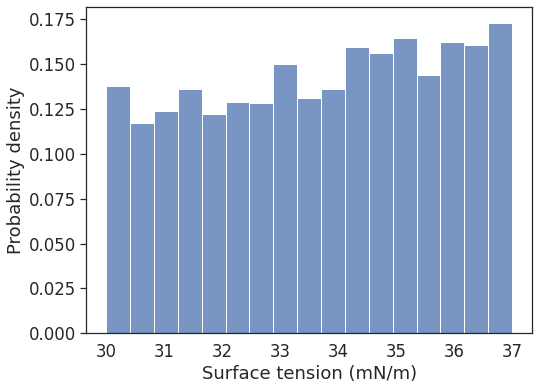

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(trial.ST, kde=False, stat="density")
plt.xlabel('Surface tension (mN/m)')
plt.ylabel('Probability density')
plt.tick_params(bottom = False)

In [ ]:
dataset=trial.copy()
dataset.reset_index(drop=True, inplace=True)
dataset

,theta,theta.1,theta.2,theta.3,theta.4,theta.5,theta.6,theta.7,theta.8,theta.9,theta.10,theta.11,theta.12,theta.13,theta.14,theta.15,theta.16,theta.17,theta.18,theta.19,theta.20,theta.21,theta.22,theta.23,theta.24,theta.25,theta.26,theta.27,theta.28,theta.29,theta.30,theta.31,theta.32,theta.33,theta.34,theta.35,theta.36,theta.37,theta.38,theta.39,...,rho.140,rho.141,rho.142,rho.143,rho.144,rho.145,rho.146,rho.147,rho.148,rho.149,rho.150,rho.151,rho.152,rho.153,rho.154,rho.155,rho.156,rho.157,rho.158,rho.159,rho.160,rho.161,rho.162,rho.163,rho.164,rho.165,rho.166,rho.167,rho.168,rho.169,rho.170,rho.171,rho.172,rho.173,rho.174,vol,Ps,ST,AR,radius
0,0.018390,0.070453,0.241554,0.367267,0.472430,0.495262,0.540086,0.563635,0.592978,0.624496,0.631869,0.735346,0.761736,0.767978,0.801781,0.819314,0.845602,0.904731,0.945489,0.953636,0.987499,1.007197,1.074737,1.081028,1.087973,1.134097,1.166377,1.214199,1.259194,1.316490,1.326178,1.397697,1.415622,1.419542,1.505420,1.564812,1.643510,1.745301,1.752077,1.796733,...,0.709584,0.704998,0.704877,0.702198,0.698548,0.693512,0.690734,0.686218,0.676664,0.667193,0.665822,0.663568,0.662954,0.658536,0.655766,0.645613,0.639703,0.637653,0.636169,0.634261,0.625925,0.621900,0.611025,0.607310,0.601198,0.597725,0.584446,0.576343,0.575958,0.575217,0.573641,0.565261,0.560752,0.560434,0.559544,1.294405,2619.206780,33.413217,0.761708,0.734393
1,0.022041,0.075593,0.087488,0.101087,0.135662,0.186399,0.194859,0.258761,0.350516,0.411052,0.461075,0.464948,0.501280,0.518807,0.523795,0.553567,0.564530,0.572439,0.585171,0.592180,0.723248,0.755960,0.778340,0.839115,0.862264,0.949038,0.986992,1.000163,1.005385,1.038040,1.073359,1.105727,1.106948,1.134582,1.149566,1.207702,1.283804,1.378974,1.384091,1.389385,...,0.618613,0.618080,0.611691,0.593697,0.581008,0.574670,0.556407,0.555398,0.545777,0.532223,0.512660,0.509805,0.502978,0.498563,0.497433,0.497299,0.495085,0.489008,0.488830,0.484279,0.483040,0.480631,0.471141,0.464666,0.463063,0.462250,0.459243,0.447125,0.442143,0.440338,0.439257,0.438004,0.436249,0.435486,0.434134,0.787534,3539.019376,34.129512,0.675805,0.642127
2,0.056031,0.058364,0.102776,0.103351,0.105074,0.124741,0.145404,0.236549,0.239968,0.253712,0.373479,0.409880,0.428987,0.461754,0.512765,0.590793,0.593071,0.612229,0.671750,0.693052,0.701034,0.709992,0.758373,0.796262,0.871989,0.877338,0.899462,0.933515,0.967438,0.973334,1.033236,1.043266,1.089315,1.098893,1.175246,1.237283,1.245626,1.249970,1.273316,1.308882,...,0.827331,0.827318,0.819351,0.811820,0.798607,0.784573,0.768828,0.762729,0.761458,0.756558,0.745859,0.743532,0.735200,0.719364,0.714380,0.689779,0.670412,0.667523,0.665143,0.664702,0.657924,0.653882,0.652574,0.652473,0.646093,0.645676,0.639607,0.637324,0.637215,0.636725,0.627611,0.626222,0.624250,0.624067,0.624013,1.908522,2592.584982,36.567592,0.740948,0.842113
3,0.015517,0.015526,0.030288,0.056381,0.112602,0.117286,0.123093,0.125995,0.128862,0.279401,0.279623,0.295042,0.329923,0.345317,0.384359,0.418488,0.423851,0.460199,0.464100,0.539094,0.553190,0.562490,0.565536,0.567737,0.576705,0.649993,0.652552,0.775830,0.777597,0.815928,0.866615,0.887305,0.935501,0.965118,1.025576,1.060370,1.174066,1.210224,1.213093,1.272522,...,0.767560,0.767089,0.763333,0.762983,0.748392,0.742645,0.734065,0.731228,0.727338,0.724405,0.714375,0.703899,0.682771,0.678574,0.672786,0.669962,0.665786,0.654057,0.653062,0.644660,0.640075,0.638566,0.636389,0.633082,0.632955,0.628805,0.628303,0.625065,0.621936,0.621850,0.613828,0.600310,0.595441,0.594926,0.592504,1.615522,2654.723492,35.503575,0.744462,0.794970
4,0.107242,0.108267,0.122372,0.131830,0.144073,0.145474,0.182008,0.186700,0.193191,0.237380,0.265815,0.285088,0.306581,0.333894,0.352027,0.379464,0.428982,0.488718,0.490272,0.493671,0.504330,0.527771,0.547422,0.555722,0.708815,0.714358,0.752408,0.786742,0.809719,0.815404,0.829600,0.896956,0.957343,0.994505,1.025948,1.057526,1.074099,1.100145,1.183607,1.202590,...,0.556463,0.555411,0.553824,0.549159,0.547506,0.546925,0.54581

### Generate new data

(1000, 353)
25.058624362886803
73.99014049139967


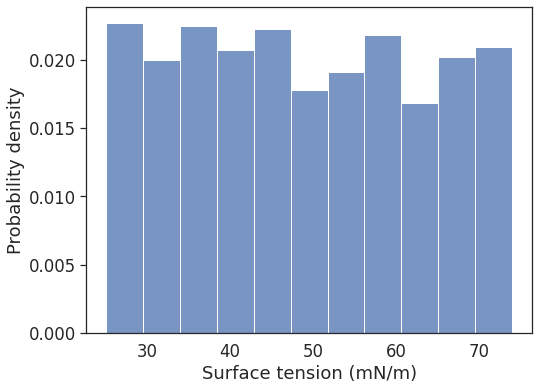

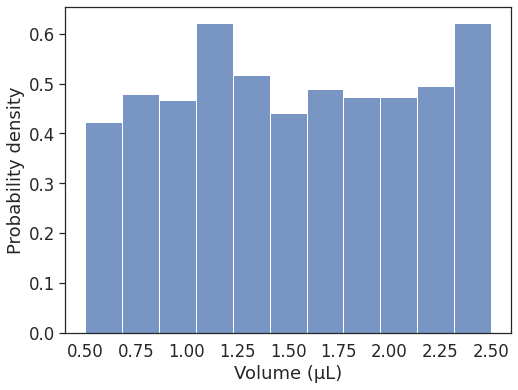

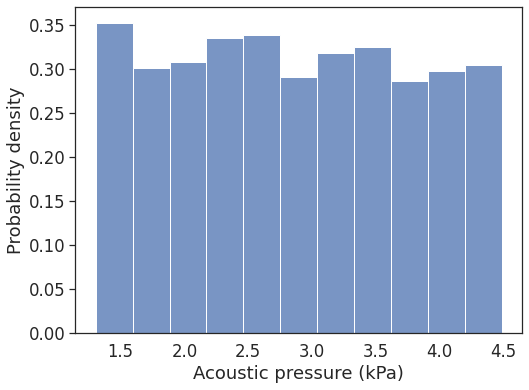

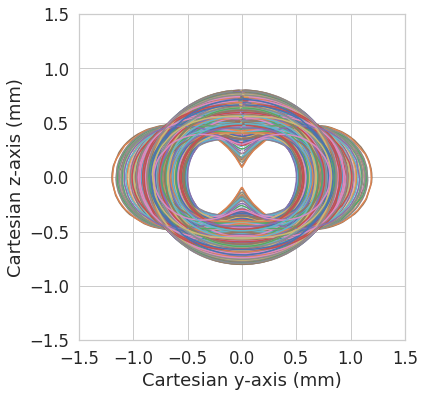

,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,rho_10,rho_11,rho_12,rho_13,rho_14,rho_15,rho_16,rho_17,rho_18,rho_19,rho_20,rho_21,rho_22,rho_23,rho_24,rho_25,rho_26,rho_27,rho_28,rho_29,rho_30,rho_31,rho_32,rho_33,rho_34,rho_35,rho_36,rho_37,rho_38,rho_39,...,theta_137,theta_138,theta_139,theta_140,theta_141,theta_142,theta_143,theta_144,theta_145,theta_146,theta_147,theta_148,theta_149,theta_150,theta_151,theta_152,theta_153,theta_154,theta_155,theta_156,theta_157,theta_158,theta_159,theta_160,theta_161,theta_162,theta_163,theta_164,theta_165,theta_166,theta_167,theta_168,theta_169,theta_170,theta_171,theta_172,theta_173,theta_174,Ps,ST
628,0.478424,0.479581,0.483457,0.483519,0.486505,0.488019,0.488658,0.489783,0.490534,0.492510,0.495249,0.497421,0.498913,0.502125,0.502571,0.508774,0.509107,0.510715,0.515234,0.515956,0.516956,0.520141,0.525795,0.526666,0.527983,0.530406,0.536592,0.537514,0.546629,0.546929,0.551474,0.552408,0.557218,0.563481,0.564089,0.564204,0.564644,0.565978,0.566060,0.567170,...,4.702407,4.745605,4.750018,4.794586,4.823371,4.888271,4.926502,5.038509,5.080220,5.091677,5.143042,5.251866,5.321899,5.377489,5.477971,5.583178,5.595632,5.611238,5.619246,5.639345,5.684323,5.708351,5.728506,5.752096,5.779908,5.786249,5.861039,5.889808,5.897119,6.048291,6.051122,6.086310,6.173605,6.176350,6.186060,6.188811,6.243557,6.281286,3630.144879,70.112104
629,0.453835,0.454440,0.455542,0.456081,0.456752,0.457554,0.460435,0.462871,0.463370,0.466786,0.467436,0.468234,0.468498,0.472576,0.474077,0.483497,0.491351,0.504354,0.504955,0.507040,0.522406,0.522647,0.529374,0.544269,0.549723,0.552675,0.558970,0.561910,0.570958,0.580720,0.584440,0.585410,0.593362,0.610494,0.623730,0.625076,0.631397,0.632259,0.632773,0.636611,...,4.907468,5.087470,5.117360,5.125218,5.190198,5.282731,5.285191,5.336735,5.344362,5.441120,5.442579,5.447145,5.483406,5.494528,5.499535,5.499653,5.501462,5.578543,5.583629,5.614221,5.704182,5.722172,5.805434,5.808448,5.831356,5.857760,5.929928,6.008111,6.034977,6.107428,6.129149,6.142656,6.159203,6.171222,6.177156,6.187738,6.214181,6.246718,4014.845562,50.548503
630,0.616025,0.616834,0.619860,0.623656,0.624639,0.626451,0.628898,0.628904,0.629229,0.631820,0.638290,0.639133,0.648704,0.656728,0.664325,0.669337,0.672792,0.674223,0.685476,0.685796,0.687399,0.691090,0.691192,0.694074,0.694444,0.695090,0.698633,0.699465,0.700513,0.703143,0.704093,0.705245,0.705735,0.706214,0.707491,0.708456,0.708874,0.709692,0.709803,0.710912,...,4.786725,4.800324,4.813133,4.832934,4.836747,4.894180,4.922842,5.013575,5.022927,5.033150,5.057875,5.067314,5.070738,5.108680,5.128832,5.168367,5.301349,5.329527,5.390508,5.421100,5.431041,5.470697,5.497536,5.609894,5.648993,5.668718,5.690391,5.813317,5.853274,5.949468,6.044156,6.077207,6.092502,6.187740,6.250905,6.264178,6.268223,6.269465,2837.826180,73.096014
631,0.560394,0.562716,0.563205,0.565407,0.567416,0.569684,0.578260,0.579603,0.587200,0.596067,0.598423,0.616595,0.623059,0.639380,0.647922,0.684171,0.687912,0.703439,0.707982,0.745278,0.762348,0.784455,0.784471,0.790101,0.795261,0.795953,0.802220,0.808979,0.812903,0.813403,0.815603,0.817594,0.821754,0.823747,0.824245,0.824325,0.824269,0.824269,0.824204,0.820968,...,4.960868,5.032999,5.054594,5.062073,5.086827,5.099633,5.228867,5.245898,5.284889,5.360816,5.363696,5.402288,5.477814,5.506059,5.548634,5.553889,5.705856,5.719949,5.730442,5.736970,5.743353,5.751807,5.823244,5.875199,5.876351,5.923463,5.975887,6.095685,6.099406,6.102251,6.105383,6.160195,6.163228,6.207100,6.210969,6.225618,6.267184,6.273983,4165.495650,69.473999
632,0.493084,0.493125,0.494770,0.495037,0.495075,0.495582,0.495669,0.495954,0.502668,0.504911,0.510135,0.514637,0.516486,0.517782,0.520844,0.527372,0.529548,0.536006,0.544315,0.546661,0.548364,0.551091,0.553310,0.553449,0.561283,0.562188,0.582843,0.584202,0.587144,0.588367,0.593978,0.594264,0.617540,0.617575,0.618657,0.624317,0.625015,0.625588,0.629781,0.630931,...,4.981662,4.992300,5.042389,5.098143,5.17895

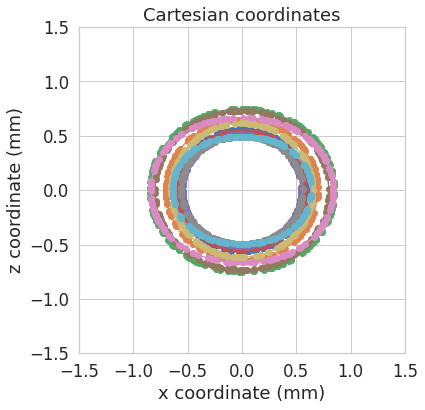

In [ ]:

num_sample=1000  # number of different ST values
sampling=175 # number of coordiante point describing the contour


new_data=gen_data(num_sample, sampling)


column_names=[]
for i in range(sampling):
  column_names.append('rho_%d' %i)
for i in range(sampling):
  column_names.append('theta_%d' %i)
column_names.append('vol')
column_names.append('Ps')
column_names.append('ST')


new_dataset = pd.DataFrame(new_data, columns=column_names)

# raw_dataset.to_csv('./dataset.csv',index=False)

clean_dataset=prep_input(new_dataset, sampling=sampling)

clean_dataset.tail()

In [ ]:
## Normalize based on training dataset

unseen_normed_rho_theta=MinMaxTransformTest(clean_dataset, train_dataset, points)

unseen_normed_data_rest = min_max_norm(clean_dataset.iloc[:, points*2:])

unseen_normed_data = unseen_normed_rho_theta.copy()
unseen_normed_data['Ps'] = unseen_normed_data_rest.Ps
unseen_normed_data['ST'] = unseen_normed_data_rest.ST


# for i in range(sampling):
#   unseen_normed_data.pop('theta_%d' %i)

unseen_normed_data.tail()


,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,rho_10,rho_11,rho_12,rho_13,rho_14,rho_15,rho_16,rho_17,rho_18,rho_19,rho_20,rho_21,rho_22,rho_23,rho_24,rho_25,rho_26,rho_27,rho_28,rho_29,rho_30,rho_31,rho_32,rho_33,rho_34,rho_35,rho_36,rho_37,rho_38,rho_39,...,theta_137,theta_138,theta_139,theta_140,theta_141,theta_142,theta_143,theta_144,theta_145,theta_146,theta_147,theta_148,theta_149,theta_150,theta_151,theta_152,theta_153,theta_154,theta_155,theta_156,theta_157,theta_158,theta_159,theta_160,theta_161,theta_162,theta_163,theta_164,theta_165,theta_166,theta_167,theta_168,theta_169,theta_170,theta_171,theta_172,theta_173,theta_174,Ps,ST
628,0.221914,0.224267,0.232151,0.232277,0.238351,0.241431,0.242730,0.245018,0.246546,0.250565,0.256137,0.260555,0.263592,0.270124,0.271031,0.283649,0.284327,0.287598,0.296790,0.298259,0.300292,0.306770,0.318271,0.320043,0.322722,0.327653,0.340235,0.342111,0.360651,0.361262,0.370506,0.372407,0.382191,0.394931,0.396168,0.396402,0.397296,0.400009,0.400177,0.402434,...,0.748411,0.755286,0.755989,0.763082,0.767663,0.777992,0.784077,0.801904,0.808542,0.810366,0.818541,0.835860,0.847007,0.855854,0.871846,0.888590,0.890573,0.893056,0.894331,0.897530,0.904688,0.908512,0.911720,0.915475,0.919901,0.920910,0.932813,0.937392,0.938556,0.962615,0.963066,0.968666,0.982560,0.982997,0.984542,0.984980,0.993693,0.999698,0.852068,0.955061
629,0.171897,0.173126,0.175369,0.176464,0.177830,0.179460,0.185322,0.190277,0.191291,0.198241,0.199562,0.201186,0.201723,0.210018,0.213070,0.232233,0.248209,0.274659,0.275881,0.280122,0.311379,0.311869,0.325553,0.355850,0.366945,0.372950,0.385754,0.391735,0.410140,0.429997,0.437564,0.439537,0.455713,0.490562,0.517484,0.520223,0.533080,0.534833,0.535879,0.543687,...,0.781048,0.809696,0.814453,0.815704,0.826046,0.840773,0.841164,0.849368,0.850582,0.865981,0.866213,0.866940,0.872711,0.874481,0.875278,0.875297,0.875585,0.887853,0.888662,0.893531,0.907849,0.910712,0.923963,0.924443,0.928089,0.932292,0.943777,0.956221,0.960497,0.972027,0.975484,0.977634,0.980268,0.982180,0.983125,0.984809,0.989018,0.994196,1.005951,0.489252
630,0.501812,0.503459,0.509614,0.517334,0.519333,0.523021,0.527997,0.528010,0.528670,0.533941,0.547102,0.548817,0.568285,0.584608,0.600061,0.610255,0.617284,0.620195,0.643085,0.643736,0.646997,0.654504,0.654712,0.660574,0.661326,0.662641,0.669849,0.671541,0.673671,0.679022,0.680955,0.683297,0.684293,0.685269,0.687866,0.689829,0.690680,0.692344,0.692569,0.694825,...,0.761831,0.763995,0.766034,0.769185,0.769792,0.778933,0.783495,0.797935,0.799424,0.801051,0.804986,0.806488,0.807033,0.813072,0.816279,0.822571,0.843736,0.848221,0.857926,0.862795,0.864377,0.870689,0.874960,0.892842,0.899065,0.902204,0.905654,0.925218,0.931578,0.946887,0.961957,0.967218,0.969652,0.984809,0.994862,0.996975,0.997619,0.997816,0.535136,1.026108
631,0.388651,0.393375,0.394369,0.398848,0.402935,0.407547,0.424992,0.427725,0.443179,0.461214,0.466007,0.502971,0.516121,0.549318,0.566695,0.640430,0.648039,0.679624,0.688865,0.764729,0.799453,0.844420,0.844453,0.855906,0.866402,0.867810,0.880557,0.894306,0.902287,0.903305,0.907780,0.911831,0.920291,0.924347,0.925359,0.925522,0.925409,0.925409,0.925276,0.918694,...,0.789547,0.801027,0.804464,0.805654,0.809594,0.811632,0.832200,0.834911,0.841116,0.853200,0.853659,0.859801,0.871821,0.876316,0.883093,0.883929,0.908115,0.910358,0.912028,0.913067,0.914083,0.915429,0.926798,0.935067,0.935250,0.942748,0.951092,0.970158,0.970751,0.971203,0.971702,0.980425,0.980908,0.987891,0.988506,0.990838,0.997453,0.998535,1.066212,0.939868
632,0.251735,0.251817,0.255163,0.255707,0.255783,0.256815,0.256992,0.257571,0.271229,0.275792,0.286417,0.295576,0.299336,0.301972,0.308201,0.321479,0.325907,0.339042,0.355945,0.360716,0.364180,0.369728,0.374241,0.374524,0.390459,0.392300,0.434315,0.437080,0.443064,0.445552,0.456965,0.457547,0.504893,0.504965,0.507166,0.518680,0.520098,0.521263,0.529794,0.532133,...,0.792856,0.794549,0.802521,0.811395,0.824256,0.829234,0.832

In [ ]:
#Import model
# folder=str('Latest_experimental_surfactants/')
# path='/content/drive/My Drive/DropLev/for_draft/In_silico/'
filename=str('Model_data_50547_ST_30.00_72.00_vol_0.50_2.50_Ps_1500_4000_model_2_MSE_0.34_20220208.csv')
# filename=str('Model_saved_1_train_1_MAE_080_20220111.h5')
# del model
model = tf.keras.models.load_model(path+filename)

# Check its architecture
model.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_116 (Dense)           (None, 50)                17600     
                                                                 
 dense_117 (Dense)           (None, 40)                2040      
                                                                 
 dense_118 (Dense)           (None, 30)                1230      
                                                                 
 dense_119 (Dense)           (None, 25)                775       
                                                                 
 dense_120 (Dense)           (None, 20)                520       
                                                                 
 dense_121 (Dense)           (None, 15)                315       
                                                                 
 dense_122 (Dense)           (None, 10)              

In [ ]:
#Make predictions

new_prediction, new_test_labels, new_mae, new_history =predict(unseen_normed_data, model)



/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


In [ ]:
#Rescale predictiong and real ST values

ST_real_test=rescaling(new_test_labels)
ST_pred_test=rescaling(new_prediction)
  

Text(0.5, 0, 'Instances')

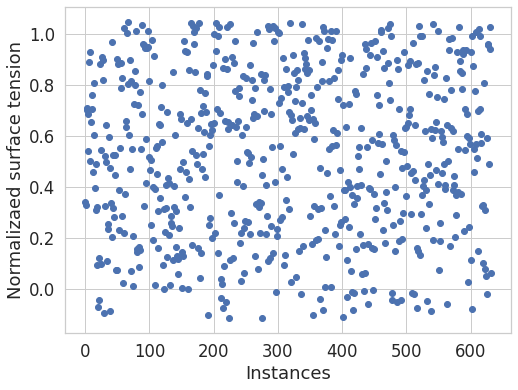

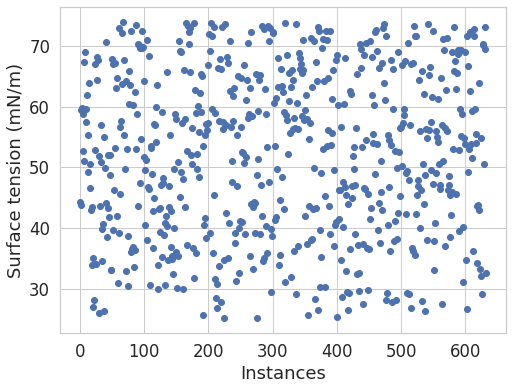

In [ ]:
#Descale target feature

#De-normalization check:
plt.figure(figsize=(8,6))
plt.scatter(range(len(new_test_labels)), new_test_labels)
plt.ylabel('Normalizaed surface tension')
plt.xlabel('Instances')

plt.figure(figsize=(8,6))
plt.scatter(range(len(ST_real_test)), ST_real_test)
plt.ylabel('Surface tension (mN/m)')
plt.xlabel('Instances')

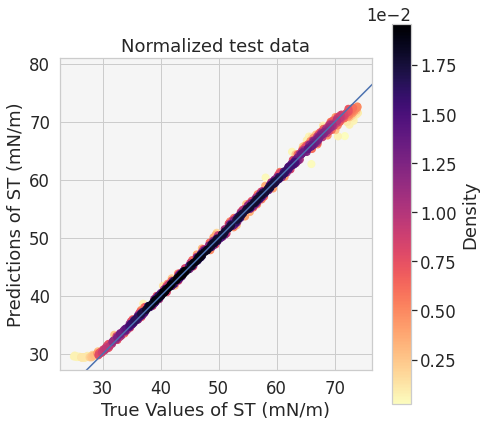

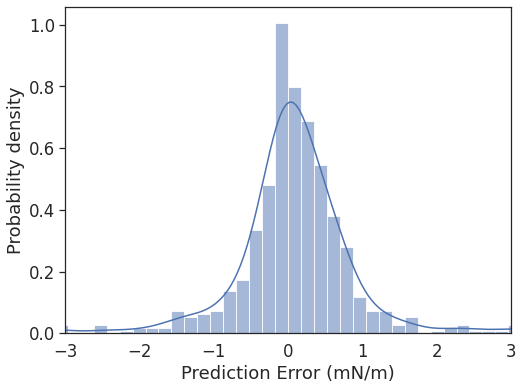

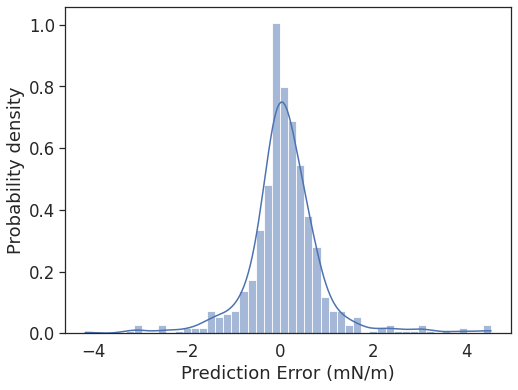

In [ ]:
error_test = ST_pred_test - ST_real_test
savefig=False
path='/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/training_outcome/'
figtype='png'

density_scatter(ST_real_test, ST_pred_test, title='Normalized test data')
plt.plot([-100, 100], [-100, 100])
if savefig==True:
  plt.savefig(path+'error_plot_test_data_'+figtype, dpi=300, format=figtype)

sns.set_theme(style='ticks', font_scale=1.5)
plt.figure(figsize=(8,6))
sns.histplot(error_test, bins = 50, kde=True, stat="density")
plt.xlabel("Prediction Error (mN/m)")
_ = plt.ylabel("Probability density")
plt.xlim(-3, 3)
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'error_distrib_test_data_lim_'+figtype, dpi=300, format=figtype)
plt.show()

plt.figure(figsize=(8,6))
sns.histplot(error_test, bins = 50, kde=True, stat="density")
plt.xlabel("Prediction Error (mN/m)")
_ = plt.ylabel("Probability density")
plt.tick_params(bottom = False)
# plt.xticks(np.arange(-0.1, 0.15, step=0.05), [-0.1 , -0.05,  0.  ,  0.05,  0.1])
if savefig==True:
  plt.savefig(path+'error_distrib_test_data_'+figtype, dpi=300, format=figtype)
plt.show()